<a href="https://colab.research.google.com/github/tuonglab/scRNAseq-tutorial/blob/master/notebook/tuong_dpt_GEX_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scRNA-seq analysis in-depth tutorial for immunology/T cell data!

This analysis notebook is meant to be a supplement to the existing tutorials out there but with a more in-depth focus on how we normally analyse immunology data. The example we will go through below is that of sorted T cell populations from human PBMC and we will go through the details as we progress. For now, we will do the first step which is to set-up the prerequisites and download the data:

In [1]:
# setup the notebook
!pip install -qqq scanpy[leiden] sc-dandelion bbknn
!pip install -qqq git+https://www.github.com/tuonglab/kttools.git
!pip install -qqq celltypist
# the session might crash after running this step as we are installing numpy. Don't worry. just reconnect and then continue with the rest below.
!celltypist --update-models
# second thing to do is to clone the repository so that we have all the data and notebooks ready to go
!git clone https://github.com/tuonglab/scRNAseq-tutorial.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.0/513.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 20.0 MB/s e

In [2]:
# change directory
import os

os.chdir("scRNAseq-tutorial")
[file for file in os.listdir() if not file.startswith(".")]

['data', 'geneset', 'notebook', 'README.md']

In [3]:
# just to make the the code run a bit quieter, i'm suppressing a few warnings here

import warnings

from numba.core.errors import NumbaDeprecationWarning, NumbaWarning

for warn in [
    NumbaDeprecationWarning,
    NumbaWarning,
    FutureWarning,
    UserWarning,
]:  # otherwise very noisy
    warnings.filterwarnings("ignore", category=warn)

# Tutorial: Single-cell RNA seq analysis using a T cell dataset (sorted from healthy PBMCs)

#### This tutorial will show you the steps involved to get you started on single cell analysis in Python using Scanpy, the toolkit for analysing single-cell gene expression.
#### It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing.
#### Depending on the complexity of your analysis, you may need to modify and expand on these steps.

# Double-Positive T scRNAseq analysis

## 1. Preprocessing and Quality Control

First, import packages needed for single-cell RNA seq analysis.

You can insert another line: `pip install "package_name"` or install them via conda/mamba/anaconda if those packages are not already installed prior to importing

In [4]:
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm

Show current directory:

In [5]:
os.getcwd()

'/content/scRNAseq-tutorial'

Print software versions:

In [6]:
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.6 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 python-igraph==0.11.4 pynndescent==0.5.12


In [7]:
ddl.logging.print_header()

dandelion==0.3.5 pandas==2.0.3 numpy==1.25.2 matplotlib==3.7.1 networkx==3.3 scipy==1.11.4


Set plotting parameters:

In [8]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

### Reading in files for analysis

For this tutorial, we have already saved the starting raw datafile as an `.h5ad` file. Hence we are reading it in with `sc.read_h5ad` to load up an `AnnData` object. However, for a normal use case, you would typically start with `cellranger` output files/folders. Therefore, refer to their [tutorial](https://scanpy.readthedocs.io/) to get an idea on how to read other file formats in.

In [97]:
# we need to read each file separately and then concatenate them

from pathlib import Path

samples = [
    "CD4_L01",
    "CD4_P01",
    "CD4_WY",
    "CD8_L01",
    "CD8_P01",
    "CD8_WY",
    "DP_L01",
    "DP_P01",
    "DP_WY",
    "V_CD4",
    "V_CD8",
    "V_DP",
]

# use a for loop to read in each sample and then concatenate at the end
adatas = []
for sample in samples:
    out_path = Path("data") / (sample + "_raw.h5ad")  # "../" means go up one folder
    adata = sc.read_h5ad(out_path)
    adatas.append(adata)

### Concatenate

Now that we have read them in and added them to a list, we want to join them all up (also known as concatenate). But how do we do that?

In [98]:
adata = sc.concat(adatas)
adata

AnnData object with n_obs × n_vars = 23350 × 36601
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    layers: 'count'

Note: this adata has gone through some pre-processing CALCULATIONS but have NOT been filtered...

## Quality control


These are the steps that Kelvin did to obtain some preprocessing parameters AFTER concatenating raw output from cell ranger, BEFORE saving it as "raw_adata_v2.h5ad"

When Kelvin ran
`ddl.pp.external.recipe_scanpy_qc(
        tmp, max_genes=10000, mito_cutoff=None, mito_startswith="MT-"
)`, he applied a quick "recipe" function from ddl to help compute PP output using these parameters in this context: {cells need to have 10,000 genes, and no mito_cutoff done}. It uses a gaussian mixture model on the mitochondrial and total gene counts to decide which cells pass or not.

It then creates a "filter_rna" column to store the final outoput, whether a cell passes QC (False), or not (True).




#### What is a way to quickly look at the cells in our metadata with the observational file?

Hint - where does `AnnData` store the `metadata`? What `type` is it?

In [99]:
adata.obs

sample sort_type donor  n_genes_by_counts  \
CD4_L01_CACCACTTCACAGTAC-1  CD4_L01       CD4   L01                500   
CD4_L01_TCATTACTCGTCGTTC-1  CD4_L01       CD4   L01                370   
CD4_L01_AGGTCCGAGACTTTCG-1  CD4_L01       CD4   L01                578   
CD4_L01_GCATACAGTAAGGGCT-1  CD4_L01       CD4   L01                771   
CD4_L01_TTGGCAACAAGTCATC-1  CD4_L01       CD4   L01                420   
...                             ...       ...   ...                ...   
V_DP_CATCGGGTCACTTACT-1        V_DP        DP     V                450   
V_DP_ACGGGCTCAAGCTGAG-1        V_DP        DP     V                650   
V_DP_GCAGCCAGTCTAGGTT-1        V_DP        DP     V                375   
V_DP_ACGATGTGTCATCCCT-1        V_DP        DP     V                444   
V_DP_CTCCTAGCATCGGGTC-1        V_DP        DP     V                140   

                            total_counts  total_counts_mt  pct_counts_mt  \
CD4_L01_CACCACTTCACAGTAC-1         906.0              4.0       0.441501   
CD4_L01_TCATTACTCGTCGTTC-1         614.0              6.0       0.977199   
CD4_L01_AGGTCCGAGACTTTCG-1        1344.0              0.0       0.000000   
CD4_L01_GCATACAGTAAGGGCT-1        2006.0             28.0       1.395813   
CD4_L01_TTGGCAACAAGTCATC-1         842.0              9.0       1.068884   
...                                  ...              ...            ...   
V_DP_CATCGGGTCACTTACT-1            941.0              0.0       0.000000   
V_DP_ACGGGCTCAAGCTGAG-1           1527.0              3.0       0.196464   
V_DP_GCAGCCAGTCTAGGTT-1            451.0              2.0       0.443459   
V_DP_ACGATGTGTCATCCCT-1           1089.0              0.0       0.000000   
V_DP_CTCCTAGCATCGGGTC-1            269.0              0.0       0.000000   

                            scrublet_score  n_genes  \
CD4_L01_CACCACTTCACAGTAC-1        0.070615      500   
CD4_L01_TCATTACTCGTCGTTC-1        0.094340      370   
CD4_L01_AGGTCCGAGACTTTCG-1        0.281437      578   
CD4_L01_GCATACAGTAAGGGCT-1        0.281437      771   
CD4_L01_TTGGCAACAAGTCATC-1        0.171854      420   
...                                    ...      ...   
V_DP_CATCGGGTCACTTACT-1           0.351801      450   
V_DP_ACGGGCTCAAGCTGAG-1           0.513514      650   
V_DP_GCAGCCAGTCTAGGTT-1           0.121951      375   
V_DP_ACGATGTGTCATCCCT-1           0.181818      444   
V_DP_CTCCTAGCATCGGGTC-1           0.047210      140   

                            gmm_pct_count_clusters_keep is_doublet filter_rna  \
CD4_L01_CACCACTTCACAGTAC-1                         True      False      False   
CD4_L01_TCATTACTCGTCGTTC-1                         True      False      False   
CD4_L01_AGGTCCGAGACTTTCG-1                         True      False      False   
CD4_L01_GCATACAGTAAGGGCT-1                         True      False      False   
CD4_L01_TTGGCAACAAGTCATC-1                         True      False      False   
...                                                 ...        ...        ...   
V_DP_CATCGGGTCACTTACT-1                            True      False      False   
V_DP_ACGGGCTCAAGCTGAG-1                           False      False       True   
V_DP_GCAGCCAGTCTAGGTT-1                           False      False       True   
V_DP_ACGATGTGTCATCCCT-1                            True      False      False   
V_DP_CTCCTAGCATCGGGTC-1                            True      False       True   

                           batch  
CD4_L01_CACCACTTCACAGTAC-1     0  
CD4_L01_TCATTACTCGTCGTTC-1     0  
CD4_L01_AGGTCCGAGACTTTCG-1     0  
CD4_L01_GCATACAGTAAGGGCT-1     0  
CD4_L01_TTGGCAACAAGTCATC-1     0  
...                          ...  
V_DP_CATCGGGTCACTTACT-1       11  
V_DP_ACGGGCTCAAGCTGAG-1       11  
V_DP_GCAGCCAGTCTAGGTT-1       11  
V_DP_ACGATGTGTCATCCCT-1       11  
V_DP_CTCCTAGCATCGGGTC-1       11  

[23350 rows x 13 columns]

#### What about genes in the metadata?

Hint - in the variable level

In [100]:
adata.var

Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2, AL627309.5, AL627309.4, AP006222.2, AL732372.1, OR4F29, AC114498.1, OR4F16, AL669831.2, LINC01409, FAM87B, LINC01128, LINC00115, FAM41C, AL645608.6, AL645608.2, AL645608.4, LINC02593, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, AL645608.7, HES4, ISG15, AL645608.1, AGRN, AL645608.5, AL645608.8, RNF223, C1orf159, AL390719.3, LINC01342, AL390719.2, TTLL10-AS1, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, AL162741.1, UBE2J2, LINC01786, SCNN1D, ACAP3, PUSL1, INTS11, AL139287.1, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20-AS1, MRPL20, AL391244.2, ANKRD65, AL391244.1, TMEM88B, LINC01770, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, AL645728.1, FNDC10, AL691432.4, AL691432.2, MIB2, MMP23B, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, AL109917.1, CALML6, TMEM52, CFAP74, AL391845.2, GABRD, AL391845.1, PRKCZ, AL590822.2, PRKCZ-AS1, FAAP20, AL590822.1, SKI, ...]

[36601 rows x 0 columns]

Now let's visualise some QC metrics. Ask yourself what is each plot trying to tell you? Eg Plot 1 = cells with highest mito content tend to also have lower read counts, suggesting low quality cells.

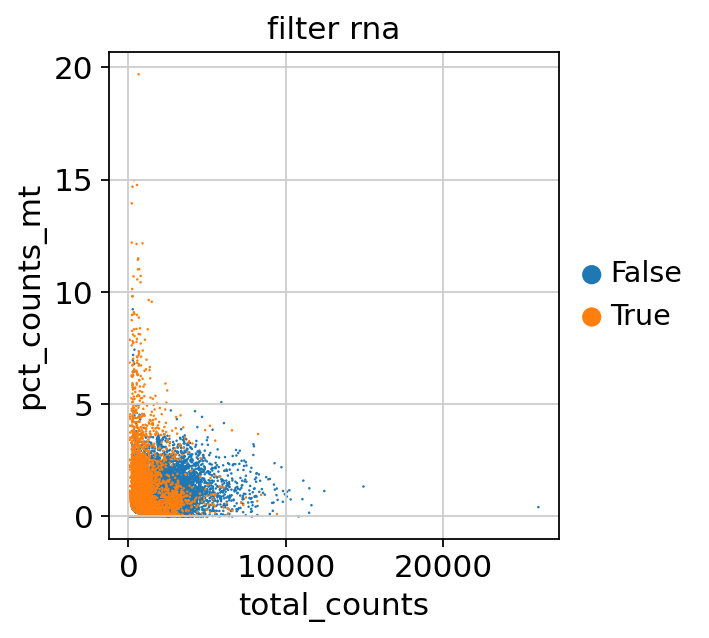

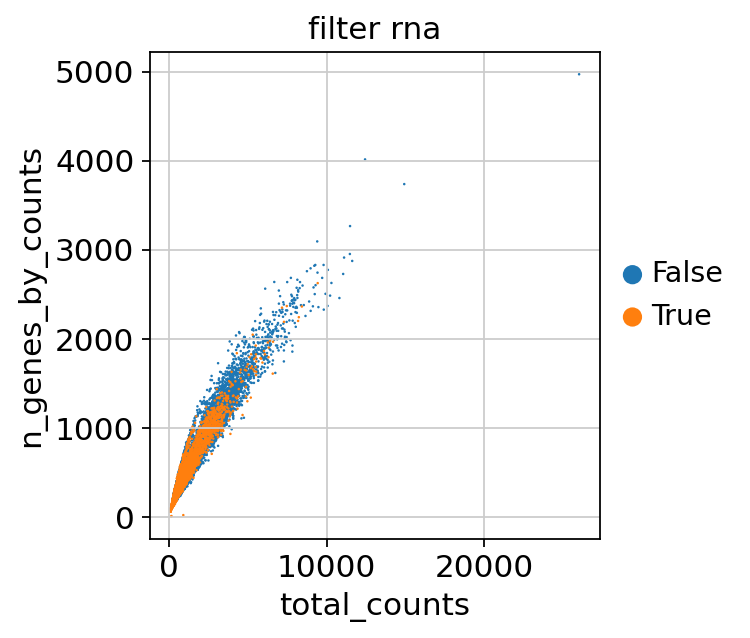

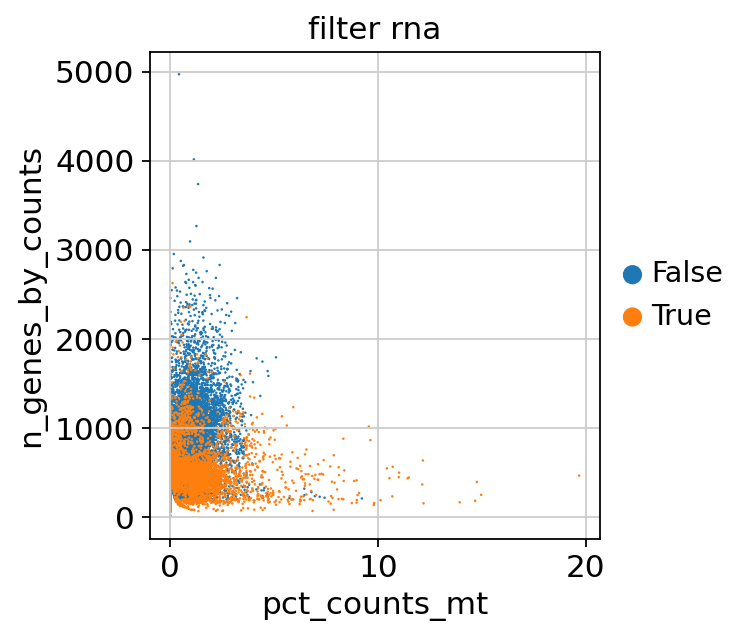

In [65]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="filter_rna")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="filter_rna")
sc.pl.scatter(adata, x="pct_counts_mt", y="n_genes_by_counts", color="filter_rna")

 - `n_genes_by_counts` = number of genes with positive counts in a cell (similar to `nFeature_RNA` in seurat)

 - `total_counts` = total number of counts for a cell, which is also known as library size (similar to `nCount_RNA` in seurat = nUMI)

Tabulate number of cells per sample...


In [66]:
pd.crosstab(adata.obs["sample"], adata.obs["filter_rna"])

# cross tab: https://stackoverflow.com/questions/21247203/how-to-make-a-pandas-crosstab-with-percentages
# https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html
# https://pbpython.com/pandas-crosstab.html

filter_rna  False  True
sample                 
CD4_L01      2026   251
CD4_P01      1642   759
CD4_WY       2341    81
CD8_L01       261  1631
CD8_P01      1340   416
CD8_WY       1896   376
DP_L01        360   973
DP_P01        998   687
DP_WY         392   923
V_CD4         731  1584
V_CD8        1273   685
V_DP         1181   543

In [67]:
## Repeating this as a percentage
# You'll just have the function that does row/row.sum(), and you use apply with axis=1 to apply it by row (or across and not within columns).

pd.crosstab(adata.obs["sample"], adata.obs["filter_rna"]).apply(
    lambda row: row / row.sum() * 100, axis=1
)

filter_rna      False       True
sample                          
CD4_L01     88.976724  11.023276
CD4_P01     68.388172  31.611828
CD4_WY      96.655656   3.344344
CD8_L01     13.794926  86.205074
CD8_P01     76.309795  23.690205
CD8_WY      83.450704  16.549296
DP_L01      27.006752  72.993248
DP_P01      59.228487  40.771513
DP_WY       29.809886  70.190114
V_CD4       31.576674  68.423326
V_CD8       65.015322  34.984678
V_DP        68.503480  31.496520

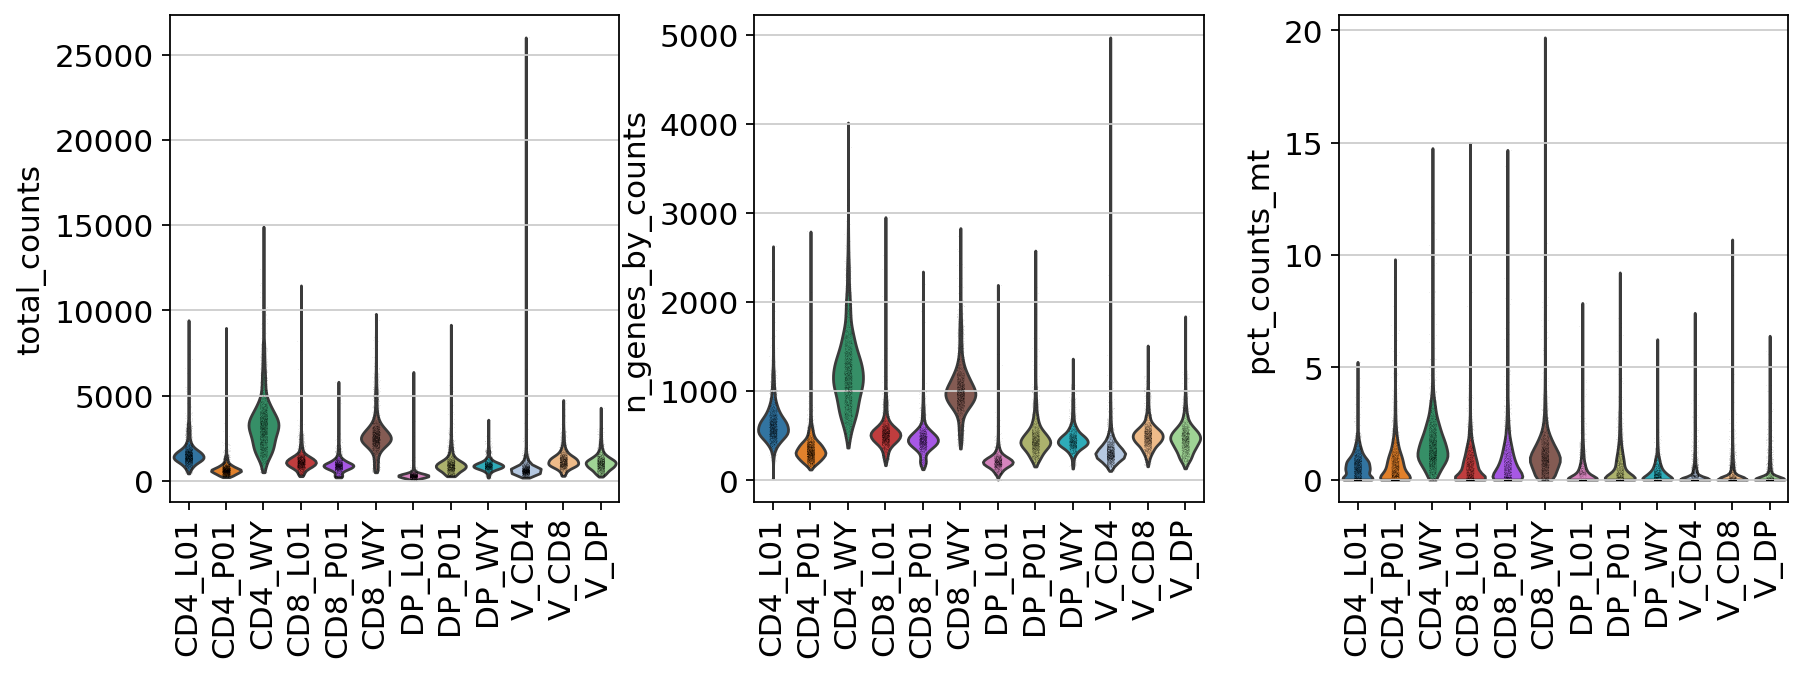

In [68]:
## Plotting violin plots for QC metrics too

sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    size=0.1,
    groupby="sample",
    multi_panel=True,
    rotation=90,
)

Continue processing with "good" cells only..

In [101]:
adata = adata[adata.obs["filter_rna"] == "False"].copy()

In [102]:
## always check after you have done some subsetting to make sure changes are applied correctly..
adata # i filtered out ~10K cells

AnnData object with n_obs × n_vars = 14441 × 36601
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    layers: 'count'

> Ask yourself, what are usual good cut-offs? Are they always appropriate?

Redo QC plots with the "good" cells post-filtering

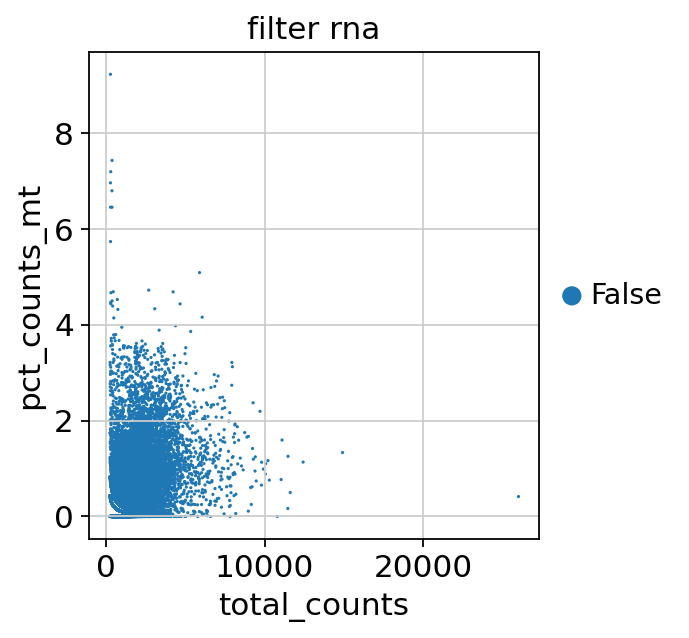

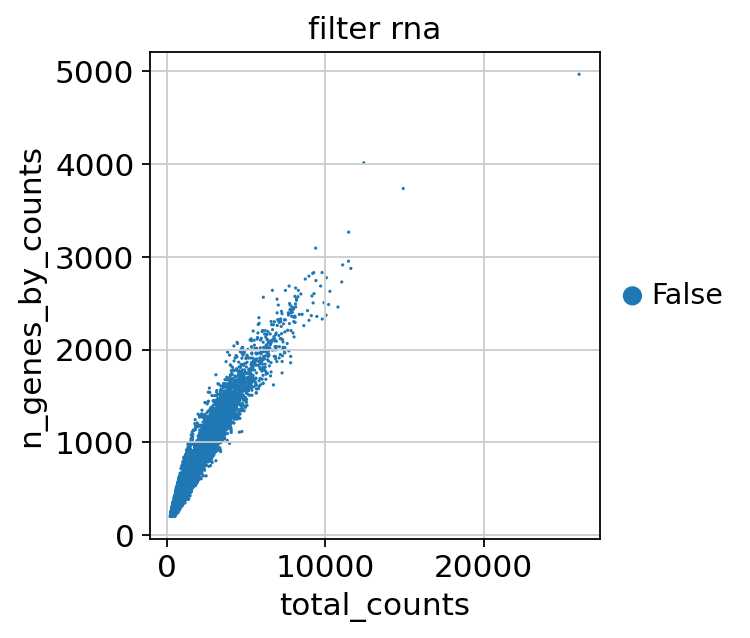

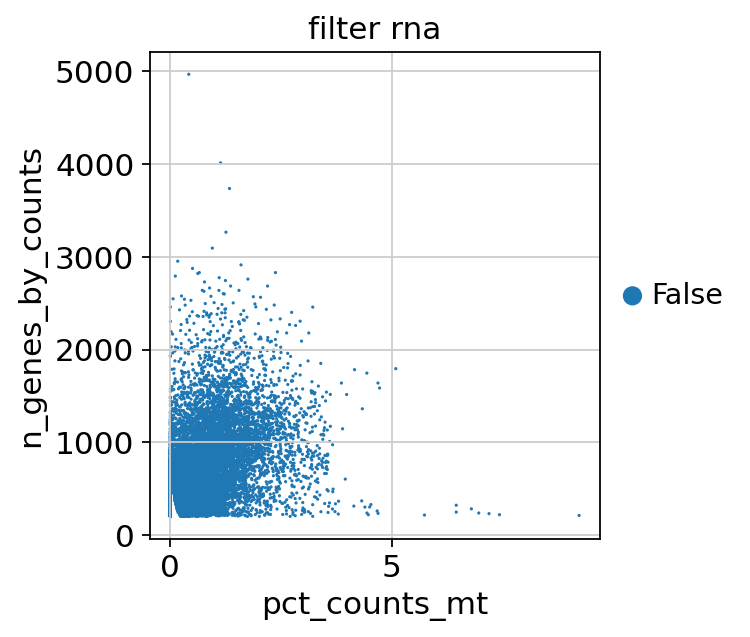

In [71]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="filter_rna")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="filter_rna")
sc.pl.scatter(adata, x="pct_counts_mt", y="n_genes_by_counts", color="filter_rna")

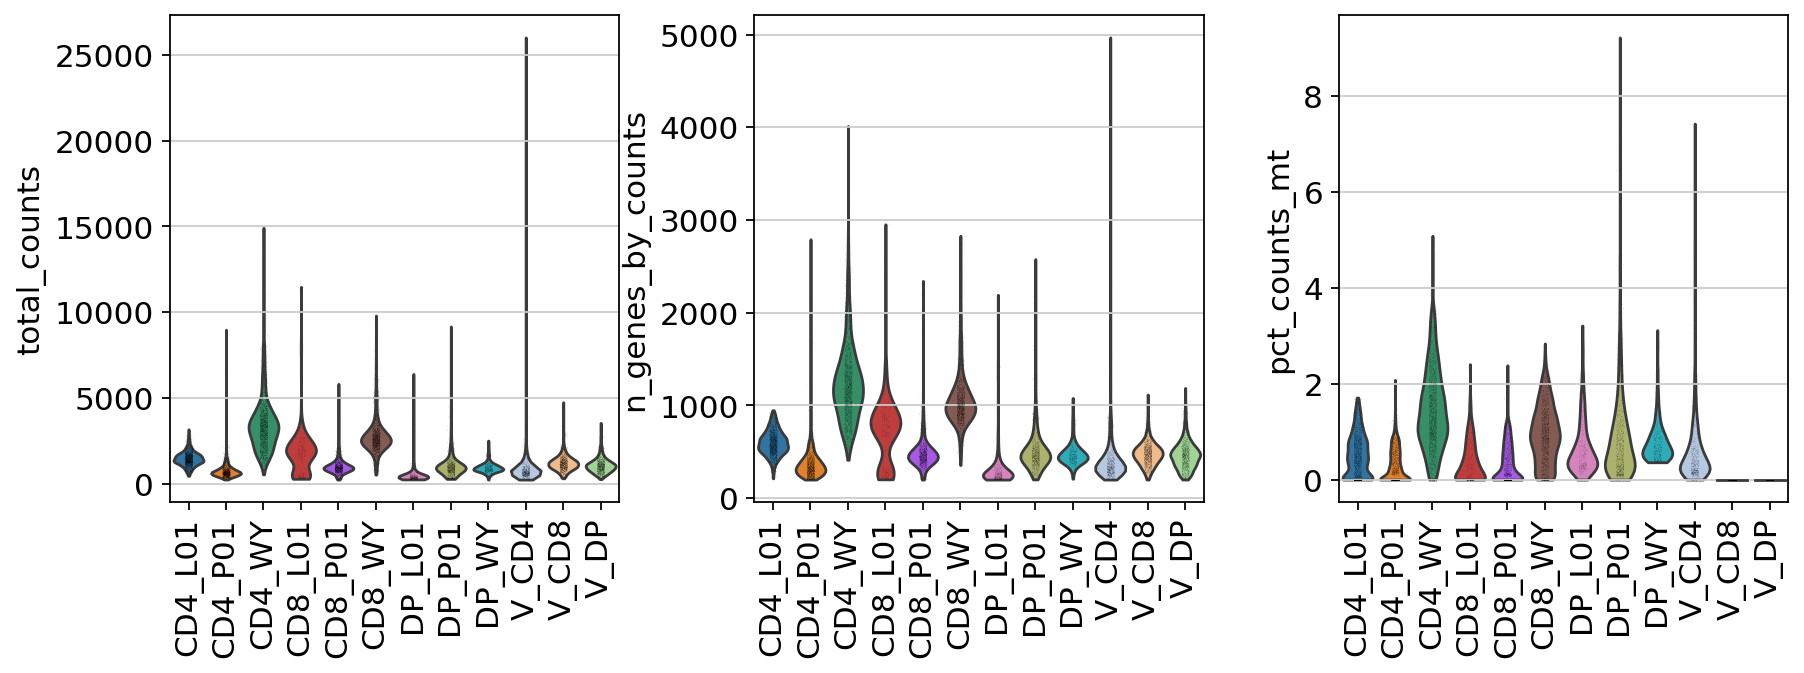

In [72]:
# also via violin plot

sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    size=0.1,
    groupby="sample",
    multi_panel=True,
    rotation=90,
)

In [73]:
# maybe just do cutoff and see what happens... So this is me thinking about how generic workflows would apply some cutoff on things like mito content. I want to see if it helps the dataset better as I can see in my violin plots there are some cells with >5% mito content.
# first i make an extra copy of the adata so I don't overwrite the MAIN object I am working on.
bdata = adata
bdata

AnnData object with n_obs × n_vars = 14441 × 36601
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    uns: 'filter_rna_colors', 'sample_colors'
    layers: 'count'

In [74]:
bdata = bdata[bdata.obs.pct_counts_mt < 5, :]
# I also want to filter out cells with low gene expression..
bdata = bdata[bdata.obs.n_genes_by_counts > 200, :]
bdata # here I can see that it has only filtered out another 20+ cells suggesting minimal changes, and the original QC metrics applied was probably stringent enough.

View of AnnData object with n_obs × n_vars = 14424 × 36601
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    uns: 'filter_rna_colors', 'sample_colors'
    layers: 'count'

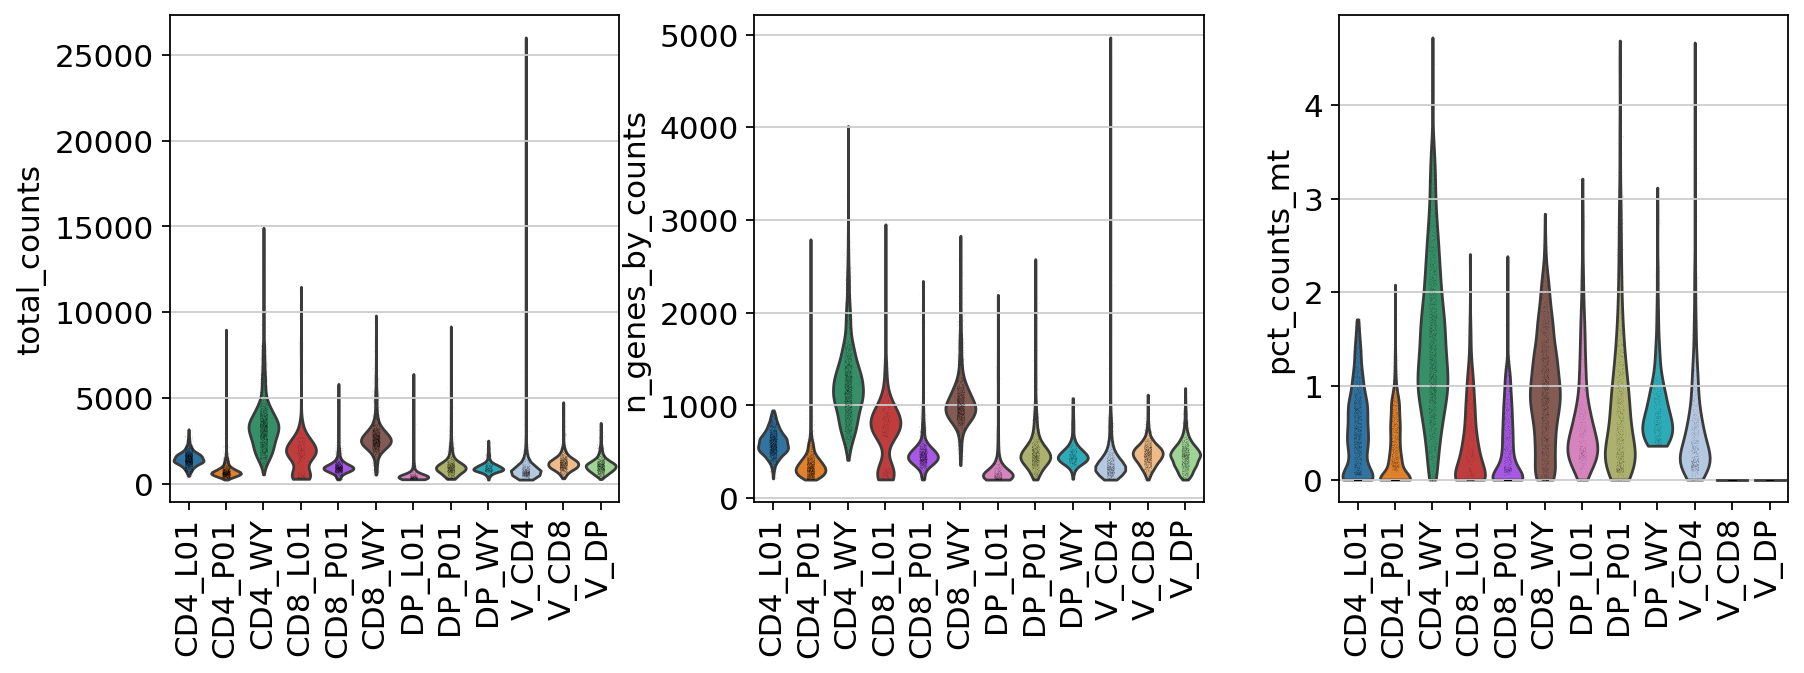

In [75]:
# also violin plot

sc.pl.violin(
    bdata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    size=0.1,
    groupby="sample",
    multi_panel=True,
    rotation=90,
)

# didn't change too much - so ignore..

In [103]:
########### Anyway let's go back to the original data... adata

# remove uninformative genes for now - this filters out genes that are not expressed in least 3 cells.

sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 14441 × 17512
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    var: 'n_cells'
    layers: 'count'

`n_obs` basically means number of observations (cells) and `n_vars` is number of variables (genes).

## Normalisation

In [77]:
# OPTIONAL - THIS STEP IS JUST TO ILLUSTRATE WHAT LOG-NORMALISATION DOES AND WHAT YOU SHOULD EXPECT..
prenorm_df = adata.to_df()
prenorm_df

AL627309.1  AL627309.5  LINC01409  LINC01128  \
CD4_L01_CACCACTTCACAGTAC-1         0.0         0.0        0.0        0.0   
CD4_L01_TCATTACTCGTCGTTC-1         0.0         0.0        0.0        0.0   
CD4_L01_AGGTCCGAGACTTTCG-1         0.0         0.0        0.0        0.0   
CD4_L01_GCATACAGTAAGGGCT-1         0.0         0.0        0.0        0.0   
CD4_L01_TTGGCAACAAGTCATC-1         0.0         0.0        0.0        0.0   
...                                ...         ...        ...        ...   
V_DP_TGTATTCGTCAACATC-1            0.0         0.0        0.0        0.0   
V_DP_TTGCCGTCAGGGTTAG-1            0.0         0.0        0.0        0.0   
V_DP_GAACGGAGTCCGCTGA-1            0.0         0.0        0.0        0.0   
V_DP_CATCGGGTCACTTACT-1            0.0         0.0        0.0        0.0   
V_DP_ACGATGTGTCATCCCT-1            0.0         0.0        0.0        0.0   

                            LINC00115  FAM41C  NOC2L  KLHL17  PLEKHN1  HES4  \
CD4_L01_CACCACTTCACAGTAC-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_TCATTACTCGTCGTTC-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_AGGTCCGAGACTTTCG-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_GCATACAGTAAGGGCT-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_TTGGCAACAAGTCATC-1        0.0     0.0    0.0     0.0      0.0   0.0   
...                               ...     ...    ...     ...      ...   ...   
V_DP_TGTATTCGTCAACATC-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_TTGCCGTCAGGGTTAG-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_GAACGGAGTCCGCTGA-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_CATCGGGTCACTTACT-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_ACGATGTGTCATCCCT-1           0.0     0.0    0.0     0.0      0.0   0.0   

                            ...  MT-ND5  MT-ND6  MT-CYB  AC145212.1  MAFIP  \
CD4_L01_CACCACTTCACAGTAC-1  ...     0.0     0.0     0.0         0.0    0.0   
CD4_L01_TCATTACTCGTCGTTC-1  ...     0.0     0.0     2.0         0.0    0.0   
CD4_L01_AGGTCCGAGACTTTCG-1  ...     0.0     0.0     0.0         0.0    0.0   
CD4_L01_GCATACAGTAAGGGCT-1  ...     0.0     0.0     1.0         0.0    0.0   
CD4_L01_TTGGCAACAAGTCATC-1  ...     0.0     0.0     1.0         0.0    0.0   
...                         ...     ...     ...     ...         ...    ...   
V_DP_TGTATTCGTCAACATC-1     ...     0.0     0.0     0.0         0.0    0.0   
V_DP_TTGCCGTCAGGGTTAG-1     ...     0.0     0.0     0.0         0.0    0.0   
V_DP_GAACGGAGTCCGCTGA-1     ...     0.0     0.0     0.0         0.0    0.0   
V_DP_CATCGGGTCACTTACT-1     ...     0.0     0.0     0.0         0.0    0.0   
V_DP_ACGATGTGTCATCCCT-1     ...     0.0     0.0     0.0         0.0    0.0   

                            AC011043.1  AL354822.1  AL592183.1  AC240274.1  \
CD4_L01_CACCACTTCACAGTAC-1         0.0         0.0         0.0         0.0   
CD4_L01_TCATTACTCGTCGTTC-1         0.0         0.0         0.0         0.0   
CD4_L01_AGGTCCGAGACTTTCG-1         0.0         0.0         0.0         0.0   
CD4_L01_GCATACAGTAAGGGCT-1         0.0         0.0         0.0         0.0   
CD4_L01_TTGGCAACAAGTCATC-1         0.0         0.0         0.0         0.0   
...                                ...         ...         ...         ...   
V_DP_TGTATTCGTCAACATC-1            0.0         0.0         0.0         0.0   
V_DP_TTGCCGTCAGGGTTAG-1            0.0         0.0         0.0         0.0   
V_DP_GAACGGAGTCCGCTGA-1            0.0         0.0         0.0         0.0   
V_DP_CATCGGGTCACTTACT-1            0.0         0.0         1.0         0.0   
V_DP_ACGATGTGTCATCCCT-1            0.0         0.0         0.0         0.0   

                            AC004556.3  
CD4_L01_CACCACTTCACAGTAC-1         0.0  
CD4_L01_TCATTACTCGTCGTTC-1         0.0  
CD4_L01_AGGTCCGAGACTTTCG-1         0.0  
CD4_L01_GCATACAGTAAGGGCT-1         0.0  
CD4_L01_TTGGCAACAAGTCATC-1         0.0  
...                                ...  
V_DP_

In [78]:
## OPTIONAL - Now, prior to normalisation, gene values can range from 0 - 10K/100K reads.
# To see this, we can either perform a rowsum of all genes for each cell or just ask what is the max read of a gene for each cell.
# Calculate row sums and find the maximum
max_row_sum = prenorm_df.sum(axis=1).max()
print("Max total gene counts in a cell is", max_row_sum)

# Find the maximum value in all rows combined
max_value_all_rows = prenorm_df.max().max()
print("Max gene count in a cell is", max_value_all_rows)

Max total gene counts in a cell is 26001.0
Max gene count in a cell is 691.0


In [104]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data:
sc.pp.log1p(adata)

# check the object
adata

AnnData object with n_obs × n_vars = 14441 × 17512
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'count'

What are some changes that you can see to confirm that normalisation has taken
place? HINT - "look for log1p" Are there any other ways to confirm?

In [105]:
## OPTIONAL - We can look into our gene matrix again to manually confirm....

postnorm_df = adata.to_df()
postnorm_df

AL627309.1  AL627309.5  LINC01409  LINC01128  \
CD4_L01_CACCACTTCACAGTAC-1         0.0         0.0        0.0        0.0   
CD4_L01_TCATTACTCGTCGTTC-1         0.0         0.0        0.0        0.0   
CD4_L01_AGGTCCGAGACTTTCG-1         0.0         0.0        0.0        0.0   
CD4_L01_GCATACAGTAAGGGCT-1         0.0         0.0        0.0        0.0   
CD4_L01_TTGGCAACAAGTCATC-1         0.0         0.0        0.0        0.0   
...                                ...         ...        ...        ...   
V_DP_TGTATTCGTCAACATC-1            0.0         0.0        0.0        0.0   
V_DP_TTGCCGTCAGGGTTAG-1            0.0         0.0        0.0        0.0   
V_DP_GAACGGAGTCCGCTGA-1            0.0         0.0        0.0        0.0   
V_DP_CATCGGGTCACTTACT-1            0.0         0.0        0.0        0.0   
V_DP_ACGATGTGTCATCCCT-1            0.0         0.0        0.0        0.0   

                            LINC00115  FAM41C  NOC2L  KLHL17  PLEKHN1  HES4  \
CD4_L01_CACCACTTCACAGTAC-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_TCATTACTCGTCGTTC-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_AGGTCCGAGACTTTCG-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_GCATACAGTAAGGGCT-1        0.0     0.0    0.0     0.0      0.0   0.0   
CD4_L01_TTGGCAACAAGTCATC-1        0.0     0.0    0.0     0.0      0.0   0.0   
...                               ...     ...    ...     ...      ...   ...   
V_DP_TGTATTCGTCAACATC-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_TTGCCGTCAGGGTTAG-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_GAACGGAGTCCGCTGA-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_CATCGGGTCACTTACT-1           0.0     0.0    0.0     0.0      0.0   0.0   
V_DP_ACGATGTGTCATCCCT-1           0.0     0.0    0.0     0.0      0.0   0.0   

                            ...  MT-ND5  MT-ND6    MT-CYB  AC145212.1  MAFIP  \
CD4_L01_CACCACTTCACAGTAC-1  ...     0.0     0.0  0.000000         0.0    0.0   
CD4_L01_TCATTACTCGTCGTTC-1  ...     0.0     0.0  3.513731         0.0    0.0   
CD4_L01_AGGTCCGAGACTTTCG-1  ...     0.0     0.0  0.000000         0.0    0.0   
CD4_L01_GCATACAGTAAGGGCT-1  ...     0.0     0.0  1.789264         0.0    0.0   
CD4_L01_TTGGCAACAAGTCATC-1  ...     0.0     0.0  2.555403         0.0    0.0   
...                         ...     ...     ...       ...         ...    ...   
V_DP_TGTATTCGTCAACATC-1     ...     0.0     0.0  0.000000         0.0    0.0   
V_DP_TTGCCGTCAGGGTTAG-1     ...     0.0     0.0  0.000000         0.0    0.0   
V_DP_GAACGGAGTCCGCTGA-1     ...     0.0     0.0  0.000000         0.0    0.0   
V_DP_CATCGGGTCACTTACT-1     ...     0.0     0.0  0.000000         0.0    0.0   
V_DP_ACGATGTGTCATCCCT-1     ...     0.0     0.0  0.000000         0.0    0.0   

                            AC011043.1  AL354822.1  AL592183.1  AC240274.1  \
CD4_L01_CACCACTTCACAGTAC-1         0.0         0.0    0.000000         0.0   
CD4_L01_TCATTACTCGTCGTTC-1         0.0         0.0    0.000000         0.0   
CD4_L01_AGGTCCGAGACTTTCG-1         0.0         0.0    0.000000         0.0   
CD4_L01_GCATACAGTAAGGGCT-1         0.0         0.0    0.000000         0.0   
CD4_L01_TTGGCAACAAGTCATC-1         0.0         0.0    0.000000         0.0   
...                                ...         ...         ...         ...   
V_DP_TGTATTCGTCAACATC-1            0.0         0.0    0.000000         0.0   
V_DP_TTGCCGTCAGGGTTAG-1            0.0         0.0    0.000000         0.0   
V_DP_GAACGGAGTCCGCTGA-1            0.0         0.0    0.000000         0.0   
V_DP_CATCGGGTCACTTACT-1            0.0         0.0    2.453329         0.0   
V_DP_ACGATGTGTCATCCCT-1            0.0         0.0    0.000000         0.0   

                            AC004556.3  
CD4_L01_CACCACTTCACAGTAC-1         0.0  
CD4_L01_TCATTACTCGTCGTTC-1         0.0  
CD4_L01_AGGTCCGAGACTTTCG-1         0.0  
CD4_L01_GCATACAGTAAGGGCT-1         0.0  
CD4_L01_TTGGCAACAAGTCATC-1         0.0  
...                   

In [106]:
## OPTIONAL - Now, post-normalisation, gene values are a lot "narrower" in range.
# To see this again, we can either perform a rowsum of all genes for each cell or just ask what is the max read of a gene for each cell.
# Calculate row sums and find the maximum
max_row_sum = postnorm_df.sum(axis=1).max()
print("Max total gene counts in a cell is", max_row_sum)

# Find the maximum value in all rows combined
max_value_all_rows = postnorm_df.max().max()
print("Max gene count in a cell is", max_value_all_rows)


Max total gene counts in a cell is 3645.7522
Max gene count in a cell is 7.6900253


# 2. Highly variable Genes

Identify and inspect highly-variable genes

In [107]:
# (Expects logarithimised data)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata

AnnData object with n_obs × n_vars = 14441 × 17512
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'count'

In [108]:
# to see genes
adata.var  # there is now a hvg column

n_cells  highly_variable     means  dispersions  dispersions_norm
AL627309.1        6            False  0.003101     2.712486          1.281120
AL627309.5        3            False  0.001069     1.763961         -1.524221
LINC01409       234             True  0.110920     2.460225          0.535039
LINC01128       301            False  0.120184     2.222507         -0.168034
LINC00115        47            False  0.017533     2.352167          0.215445
...             ...              ...       ...          ...               ...
AC011043.1        6            False  0.002102     1.805421         -1.401602
AL354822.1       17            False  0.009610     2.539396          0.769192
AL592183.1      134            False  0.059867     2.425862          0.433407
AC240274.1       24             True  0.016193     3.112034          2.462817
AC004556.3      171            False  0.061654     2.119783         -0.471849

[17512 rows x 5 columns]

In [109]:
### to get structure of dataframe
adata.var.info()
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17512 entries, AL627309.1 to AC004556.3
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_cells           17512 non-null  int64  
 1   highly_variable   17512 non-null  bool   
 2   means             17512 non-null  float64
 3   dispersions       17512 non-null  float64
 4   dispersions_norm  17512 non-null  float32
dtypes: bool(1), float32(1), float64(2), int64(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 14441 entries, CD4_L01_CACCACTTCACAGTAC-1 to V_DP_ACGATGTGTCATCCCT-1
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   sample                       14441 non-null  category
 1   sort_type                    14441 non-null  category
 2   donor                        14441 non-null  category
 3   n_genes_by_counts            14441 

In [110]:
### to get the number of HV genes... because the column "highly_variable" is a boolean vector - ie it gives True (1) or False (0), you can use sum function to know...
print(adata.var.highly_variable.sum())

3001


Plot out the number of highly variable genes

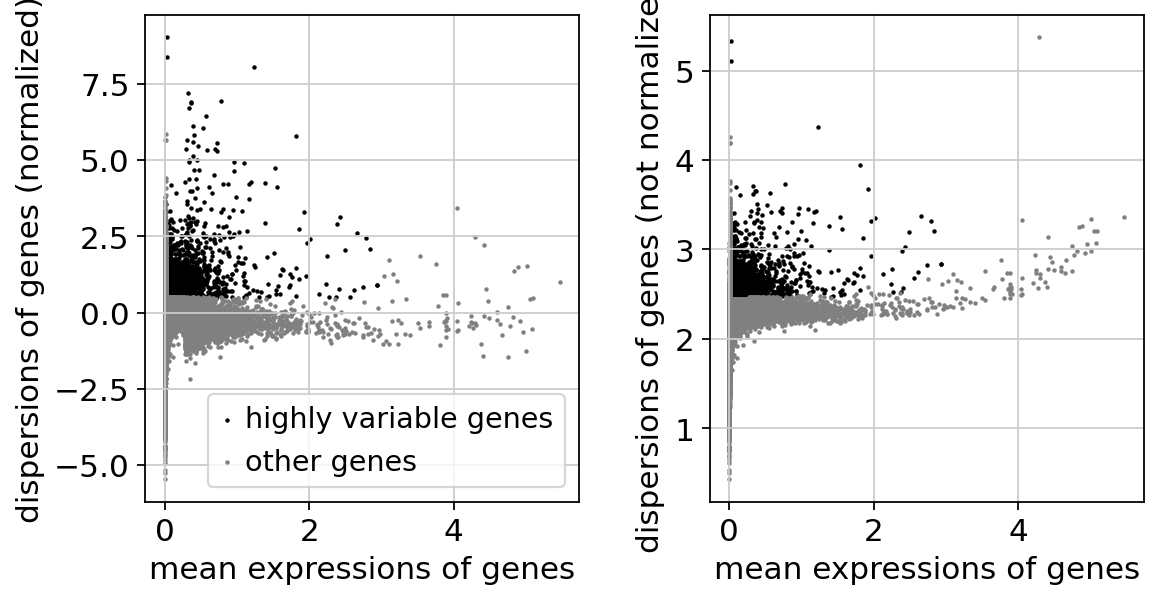

In [111]:
sc.pl.highly_variable_genes(adata)

To inspect HV genes, first, create a dataframe containing the info.

In [112]:
hvg = pd.DataFrame(adata.var.highly_variable)
hvg

highly_variable
AL627309.1            False
AL627309.5            False
LINC01409              True
LINC01128             False
LINC00115             False
...                     ...
AC011043.1            False
AL354822.1            False
AL592183.1            False
AC240274.1             True
AC004556.3            False

[17512 rows x 1 columns]

In [113]:
# to know the str
pd.DataFrame.info(hvg)

<class 'pandas.core.frame.DataFrame'>
Index: 17512 entries, AL627309.1 to AC004556.3
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   highly_variable  17512 non-null  bool 
dtypes: bool(1)
memory usage: 670.0+ KB


Add col name 'HV_status' and print hvg

In [114]:
hvg.columns = ["HV_status"]
print(hvg)

            HV_status
AL627309.1      False
AL627309.5      False
LINC01409        True
LINC01128       False
LINC00115       False
...               ...
AC011043.1      False
AL354822.1      False
AL592183.1      False
AC240274.1       True
AC004556.3      False

[17512 rows x 1 columns]


Get only the True ones..

In [115]:
hvg_T = hvg.loc[hvg["HV_status"] == True]
hvg_T[:50]

HV_status
LINC01409        True
FAM41C           True
KLHL17           True
TNFRSF18         True
TNFRSF4          True
ACAP3            True
DVL1             True
ATAD3C           True
CDK11A           True
SLC35E2A         True
AL139246.3       True
MEGF6            True
AL031848.2       True
RERE             True
CA6              True
H6PD             True
SPSB1            True
TMEM201          True
PIK3CD           True
CLSTN1           True
CTNNBIP1         True
AL357140.2       True
KIF1B            True
PEX14            True
CLCN6            True
VPS13D           True
PRDM2            True
FBXO42           True
AL137802.2       True
NBPF1            True
TMCO4            True
UBXN10-AS1       True
EIF4G3           True
ZNF436-AS1       True
STPG1            True
NIPAL3           True
RCAN3            True
NCMAP-DT         True
RUNX3            True
PDIK1L           True
SH3BGRL3         True
CRYBG2           True
ZNF683           True
ZDHHC18          True
FGR              True
STX12            True
EYA3             True
AL353622.1       True
PHACTR4          True
EPB41            True

In [116]:
########### see all the variables here..   ##############
%who_ls

['NumbaDeprecationWarning',
 'NumbaWarning',
 'Path',
 'adata',
 'adatas',
 'bdata',
 'ddl',
 'df',
 'hvg',
 'hvg_T',
 'i',
 'max_row_sum',
 'max_value_all_rows',
 'os',
 'out_path',
 'pd',
 'postnorm_df',
 'prenorm_df',
 're',
 'sample',
 'samples',
 'sc',
 'tools',
 'tqdm',
 'warn',
 'warnings']

## Removing VDJ genes from HVG genes manually

### So how does T-cell receptor (TCR) differ from B-cell receptor (TCR)?
TCR has a single pair of alpha and beta chains while BCR contains two pairs of light and heavy chains.

In the examples below, TCR can be expressed as TR while BCR can be expressed as IG.

**The code below is for BCR data.**

Because this is 10x 5' data - there is a lot of VDJ genes that are picked up (in abundance), and because they do look different from each donor, it can be mis-computed as HVG - therefore, <b> REMOVE THEM </b>.

In [93]:
import re

for i in adata.var.index:
    if re.search("^IG[HKL][VDJC]", i):
        adata.var.at[i, "highly_variable"] = False

It uses the `re` module, which stands for regular expressions, to search for specific patterns in the index values.

Let's break down the code step by step:

 - `for i in adata.var.index` -> This initiates a loop that iterates over each value (i) in the index of the adata.var object.

 - `if re.search("^IG[HKL][VDJC]", i)`
    - This line uses regular expressions to check if the current index value (i) matches a specific pattern. The regular expression pattern is as follows:

      - `^`: Asserts the position at the start of the string.
      - `IG`: The first two characters match the characters "IG" literally.
      - `[HKL]`: The next character matches either "H", "K", or "L".
      - `[VDJC]`: The next character either "V", "D", "J", or "C".      

Therefore, the regular expression is looking for index values that either start with "IG", followed by "H", "K", or "L", and then one of "V", "D", "J", or "C".

  - `adata.var.at[i, "highly_variable"] = False` : If the regular expression matches the current index value (i), it sets the corresponding value of "highly_variable" in the adata.var object to False.

In summary, this modified code is looping through the index values of the adata.var object and using a regular expression to identify specific patterns in the index values that match either the BCR V/D/J gene pattern. If a match is found, it sets the corresponding "highly_variable" value to False. This code could be used to mark certain entries in the adata.var object as not highly variable based on the new regular expression pattern. Just like before, it's important to ensure that you understand the data and the intention behind the code before executing it, as regular expressions can be tricky and their behavior can be sensitive to small changes in the pattern.

The purpose of this code seems to be to mark certain entries in the adata.var object as "not highly_variable" based on the matching pattern defined in the regular expression.

### Now, repeat the code but only do it from the TCR dataset

Do you understand what the regex pattern is looking for now?

In [94]:
import re

for i in adata.var.index:
    if re.search("^TR[AB][VDJ]", i):
        adata.var.at[i, "highly_variable"] = False

### Now how to use one regex pattern to catch both TCR and BCR?

In [117]:
import re

for i in adata.var.index:
    if re.search("^TR[AB][VDJ]|^IG[HKL][VDJC]", i):
        adata.var.at[i, "highly_variable"] = False

Let's re-inspect the highly-variable gene list

In [118]:
hvg = pd.DataFrame(adata.var.highly_variable)
hvg_T = hvg.loc[hvg["highly_variable"] == True]
hvg_T  # 2915 genes...

highly_variable
LINC01409              True
FAM41C                 True
KLHL17                 True
TNFRSF18               True
TNFRSF4                True
...                     ...
MT-ND4L                True
MT-ND4                 True
MT-CYB                 True
MAFIP                  True
AC240274.1             True

[2915 rows x 1 columns]

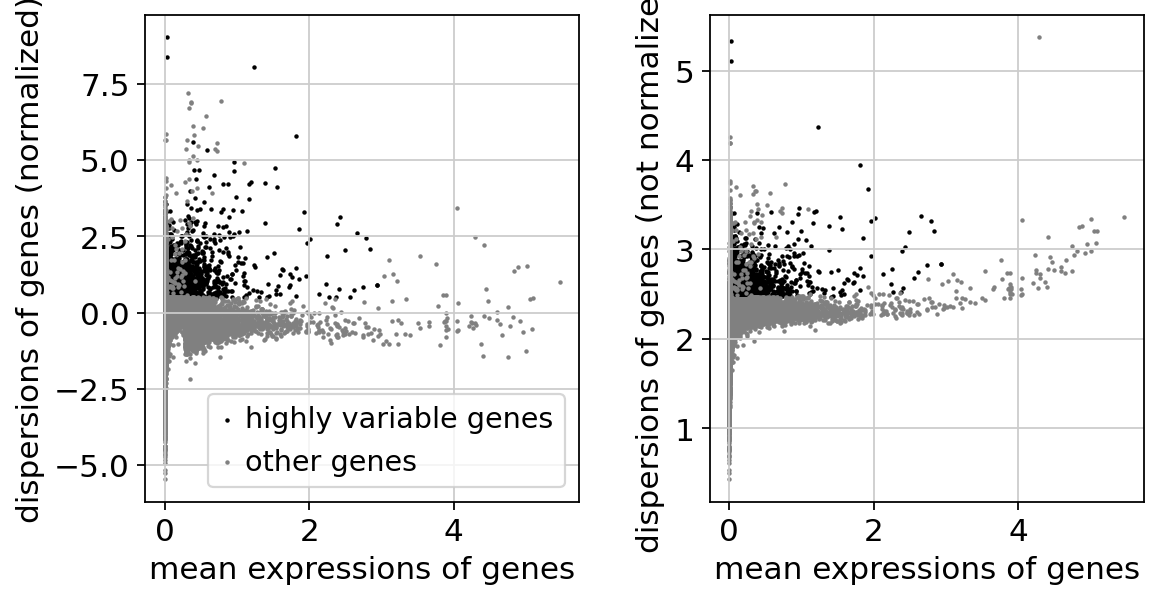

In [119]:
sc.pl.highly_variable_genes(adata)

### Explain what adata.raw, adata.layers and adata.X mean; + include examples after 40 using numpy - normal vs log-transformed
✅ Megan: i have done up examples of normal vs log-transformed in the "NORMALISATION" SECTION. Not with numpy though...

### What is the difference between adata.raw, adata.X, and adata.raw.X?


`adata.raw` = Setting the `.raw` attribute of the `AnnData` object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

The raw attribute is initialized with the current content of an object by setting:

In [ ]:
adata.raw = adata

You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [ ]:
test_data = adata.raw.to_adata()
test_data

adata.X represents the data matrix of n_obs × n_var and so is referencing an explicit layer of .X

But in our case we will need the .raw attribute to run the next line

# 3. Perform Dimensionality Reduction

## 3a. PCA

In [120]:
# Actually do the filtering for PCA
adata = adata[
    :, adata.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
adata

AnnData object with n_obs × n_vars = 14441 × 2915
    obs: 'sample', 'sort_type', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet_score', 'n_genes', 'gmm_pct_count_clusters_keep', 'is_doublet', 'filter_rna', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'count'

#### Regress out effects of "total_counts" per cell and percentage of mt genes expressed ("pct_counts_mt").

In [121]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

#### Scale each gene to unit variance. Clip values exceeding std of 10.

In [122]:
sc.pp.scale(adata, max_value=10)

Why do we need to scale the data?

In [129]:
## OPTIONAL - Scaling the data adjusts the expression values of genes across cells to make them more comparable.
# It often involves a centering and scaling step, which will typically give negative - positive values in a small range.

scaled_df = adata.to_df()
print(scaled_df[5:])

# To see this, we will look at the min, max and max sum of gene values for each cell.

# Get the min values in all rows combined
min_value_all_rows = scaled_df.min().min()
print("Min gene count in a cell is", min_value_all_rows)

# Calculate row sums and find the maximum
max_row_sum = scaled_df.sum(axis=1).max()
print("Max total gene counts in a cell is", max_row_sum)

# Find the maximum value in all rows combined
max_value_all_rows = scaled_df.max().max()
print("Max gene count in a cell is", max_value_all_rows)

                            LINC01409    FAM41C    KLHL17  TNFRSF18   TNFRSF4  \
CD4_L01_GTGGGTCTCGCTAGCG-1  -0.110760 -0.045866 -0.057867 -0.085347 -0.170531   
CD4_L01_CGTTGGGTCATCATTC-1  -0.103943 -0.043070 -0.054355 -0.089129 -0.173244   
CD4_L01_AGTGTCAGTAAGGGCT-1  -0.133112 -0.050882 -0.076975 -0.085592 -0.181060   
CD4_L01_AGCCTAAGTGGAAAGA-1  -0.108908 -0.045306 -0.056548 -0.085767 -0.170335   
CD4_L01_CTACATTAGACAGGCT-1  -0.113039 -0.044742 -0.062805 -0.090352 -0.179255   
...                               ...       ...       ...       ...       ...   
V_DP_TGTATTCGTCAACATC-1     -0.095391 -0.051419 -0.028270 -0.057762 -0.121170   
V_DP_TTGCCGTCAGGGTTAG-1     -0.096602 -0.050237 -0.031962 -0.062201  7.410935   
V_DP_GAACGGAGTCCGCTGA-1     -0.108997 -0.038136 -0.069769 -0.107664 -0.204015   
V_DP_CATCGGGTCACTTACT-1     -0.099817 -0.047098 -0.041771 -0.073996 -0.148122   
V_DP_ACGATGTGTCATCCCT-1     -0.101125 -0.045821 -0.045759 -0.078792 -0.156084   

                           

In [130]:
## get PCA
sc.tl.pca(adata, svd_solver="arpack")

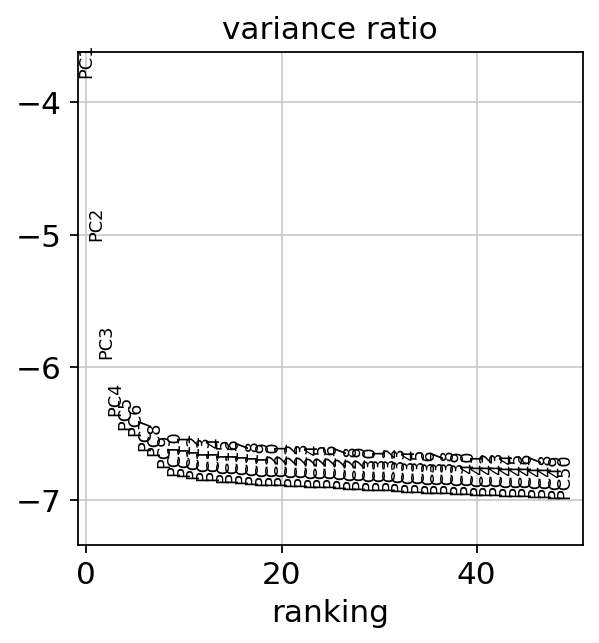

In [131]:
# get elbow plot to see variance contribution by each pc
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [132]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## n_neighbor: The size of local neighborhood (in terms of number of neighboring data
# points) used for manifold approximation. Larger values result in more
# global views of the manifold, while smaller values result in more local
# data being preserved. In general values should be in the range 2 to 100.
# If `knn` is `True`, number of nearest neighbors to be searched. If `knn`
# is `False`, a Gaussian kernel width is set to the distance of the
# `n_neighbors` neighbor.

## 3b. UMAP Visualisation

Embedding the neighbourhood graph using UMAP

In [133]:
sc.tl.umap(adata, min_dist=0.3)  # 0.3 is personal preference

#### Visualise UMAP:

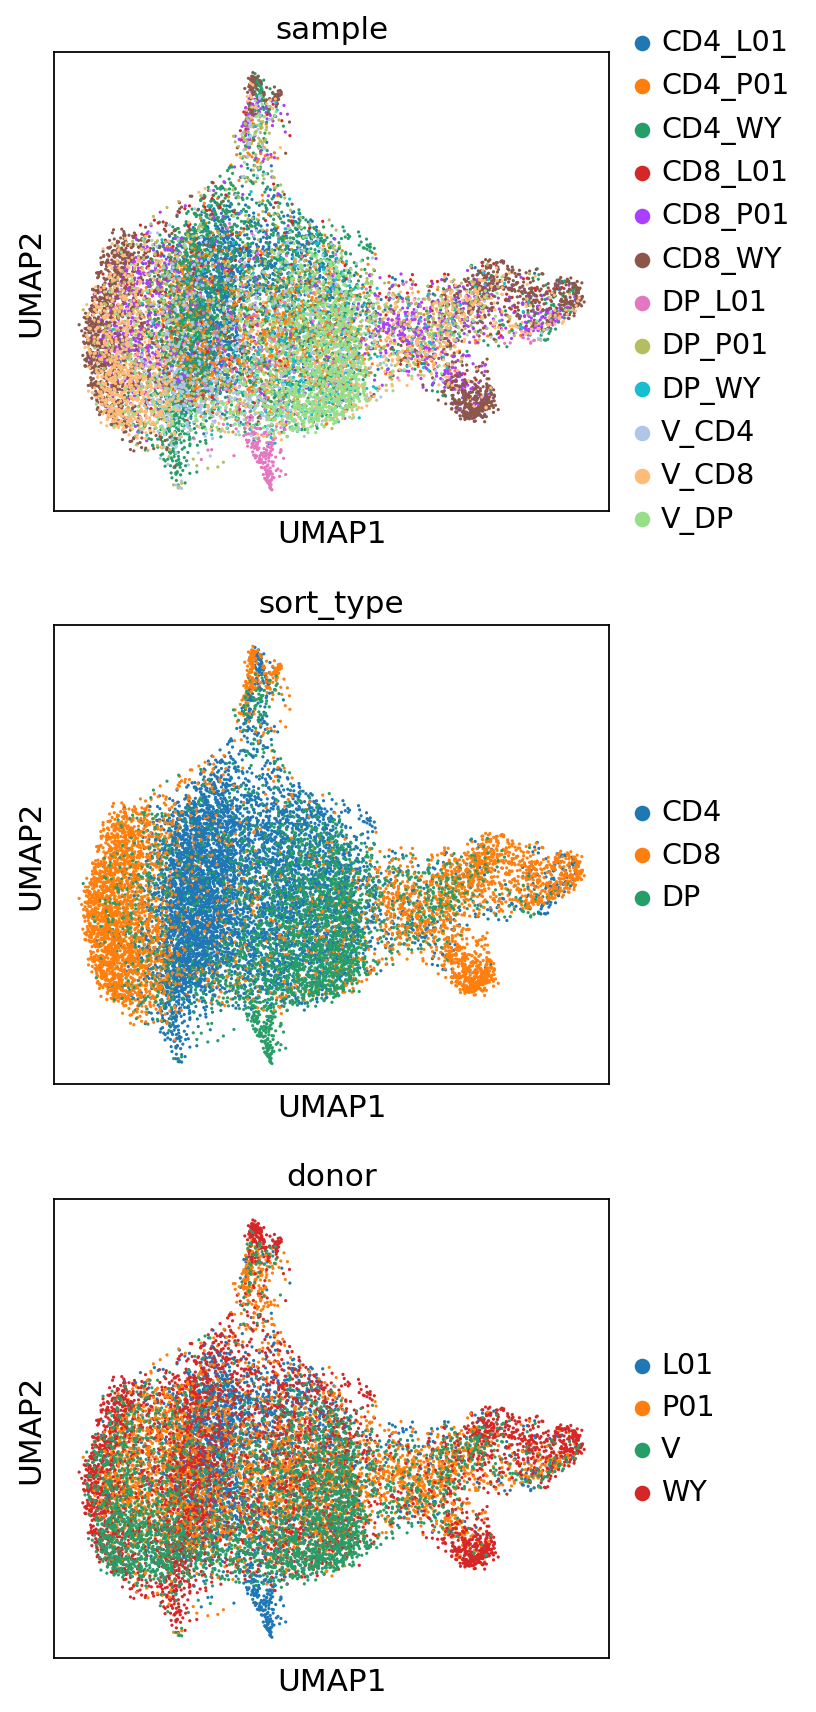

In [134]:
sc.pl.umap(
    adata,
    color=[
        "sample",
        "sort_type",
        "donor",
    ],
    ncols=1,
)

In [135]:
#### plotting multiple small umaps of the same parameter, similar to faceting/split.by


## https://github.com/scverse/scanpy/issues/955
def cluster_small_multiples(
    adata, clust_key, size=30, frameon=False, legend_loc=None, **kwargs
):
    tmp = adata.copy()

    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=adata.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs
    )

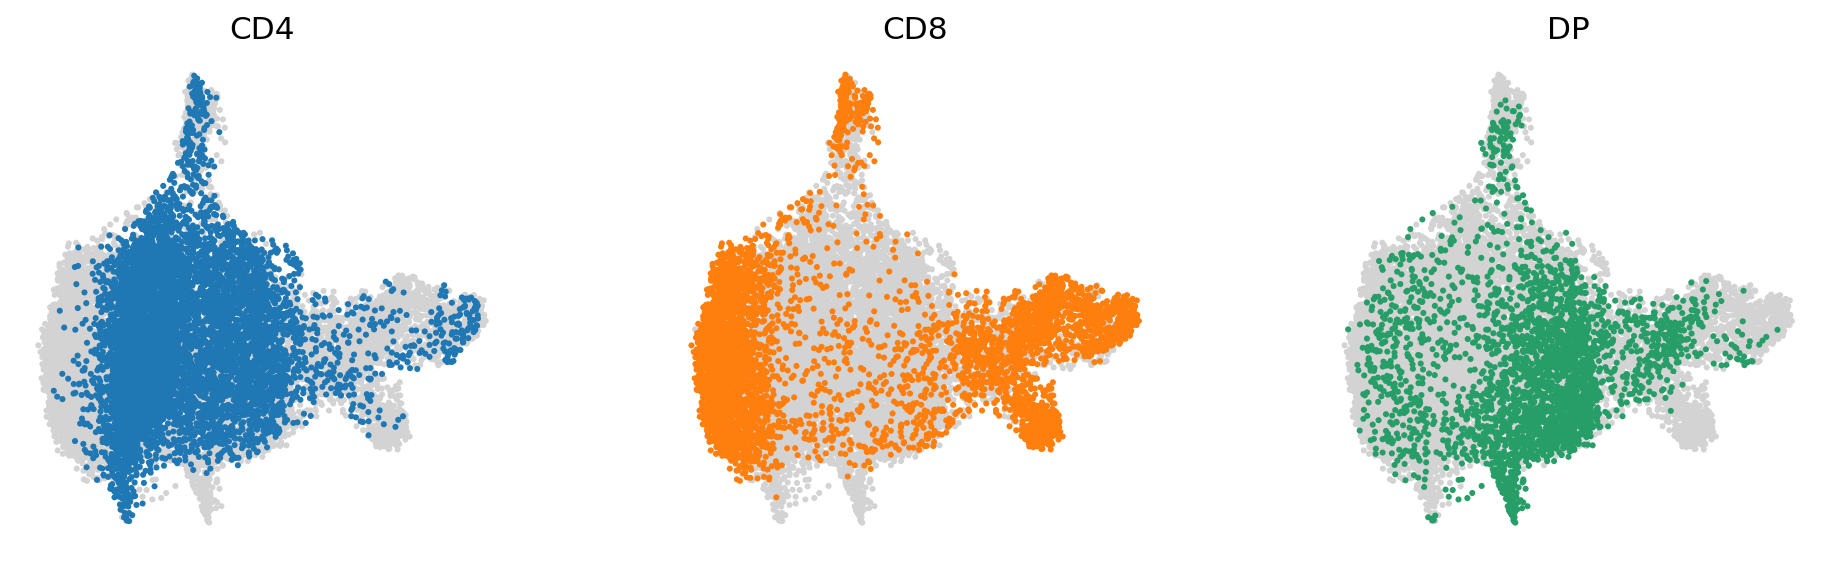

In [136]:
cluster_small_multiples(adata, "sort_type")

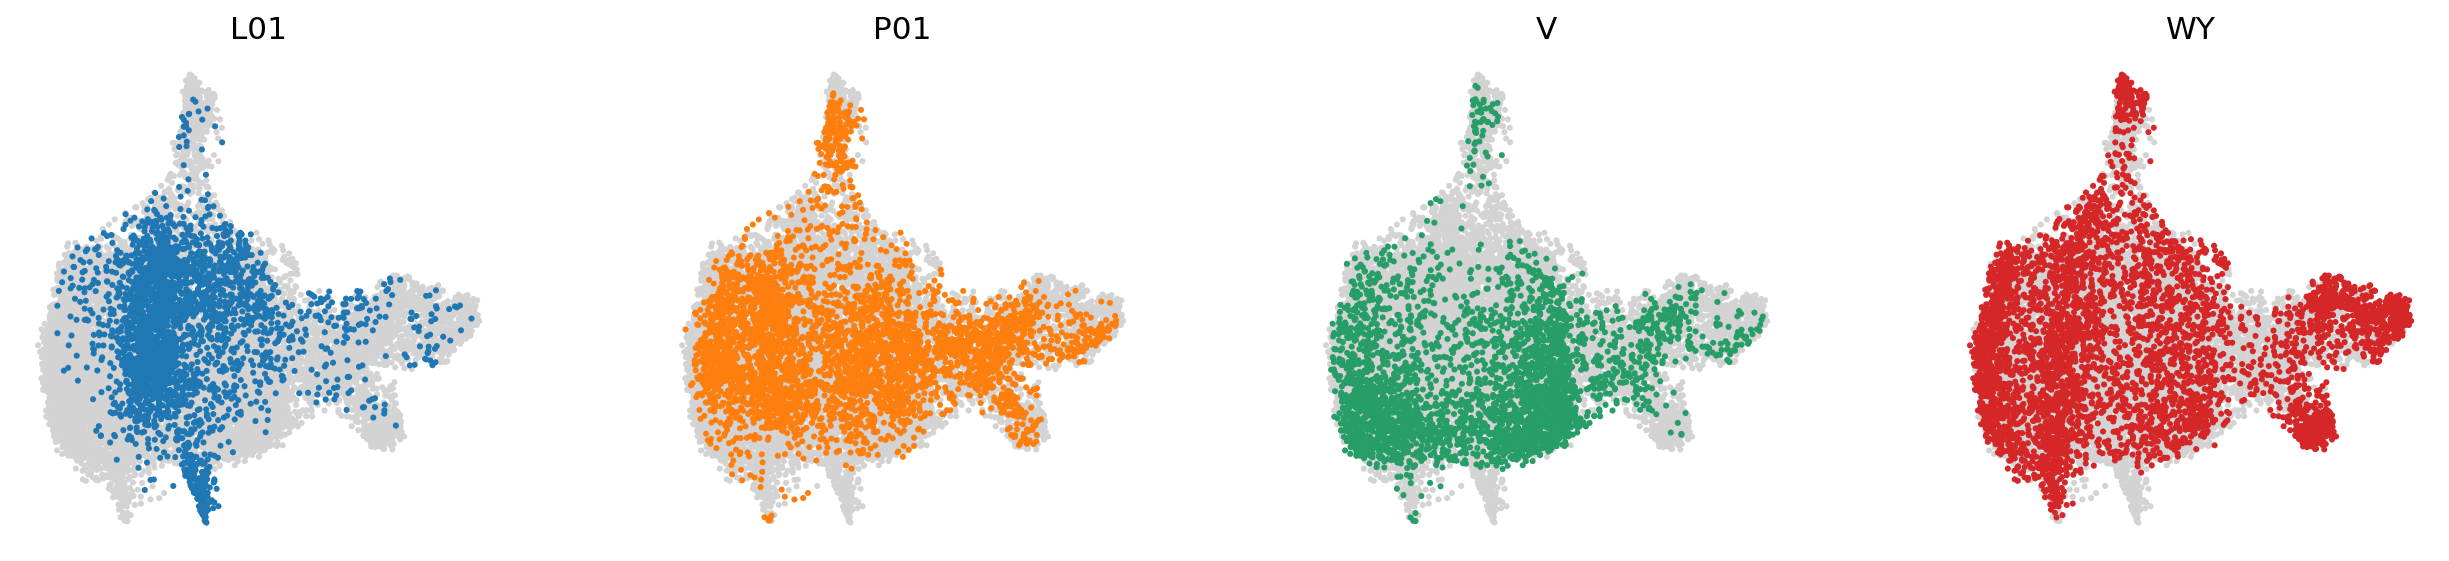

In [137]:
cluster_small_multiples(adata, "donor")
# not too much donor biasness..

Next, I want to visualise key lineage genes on the UMAP that is subset by their sort_type.

#### Can I do a quick QC: subset data by sort type, and plot the relevant marker genes on them?

We can create an object by sorting for CD4 and then check the table of variables:

In [138]:
adata.obs.info()
adata_CD4 = adata[adata.obs["sort_type"] == "CD4"]
adata_CD4.obs

<class 'pandas.core.frame.DataFrame'>
Index: 14441 entries, CD4_L01_CACCACTTCACAGTAC-1 to V_DP_ACGATGTGTCATCCCT-1
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   sample                       14441 non-null  category
 1   sort_type                    14441 non-null  category
 2   donor                        14441 non-null  category
 3   n_genes_by_counts            14441 non-null  int32   
 4   total_counts                 14441 non-null  float32 
 5   total_counts_mt              14441 non-null  float32 
 6   pct_counts_mt                14441 non-null  float32 
 7   scrublet_score               14441 non-null  float64 
 8   n_genes                      14441 non-null  int64   
 9   gmm_pct_count_clusters_keep  14441 non-null  bool    
 10  is_doublet                   14441 non-null  category
 11  filter_rna                   14441 non-null  category
 12  batch                 

sample sort_type donor  n_genes_by_counts  \
CD4_L01_CACCACTTCACAGTAC-1  CD4_L01       CD4   L01                500   
CD4_L01_TCATTACTCGTCGTTC-1  CD4_L01       CD4   L01                370   
CD4_L01_AGGTCCGAGACTTTCG-1  CD4_L01       CD4   L01                578   
CD4_L01_GCATACAGTAAGGGCT-1  CD4_L01       CD4   L01                771   
CD4_L01_TTGGCAACAAGTCATC-1  CD4_L01       CD4   L01                420   
...                             ...       ...   ...                ...   
V_CD4_TCTCATACAGGATTGG-1      V_CD4       CD4     V                240   
V_CD4_CTCAGAATCTGGAGCC-1      V_CD4       CD4     V                496   
V_CD4_TGACAACCACATTTCT-1      V_CD4       CD4     V                441   
V_CD4_TGAGCATGTACCGGCT-1      V_CD4       CD4     V                466   
V_CD4_TACGGATTCTGCGTAA-1      V_CD4       CD4     V                454   

                            total_counts  total_counts_mt  pct_counts_mt  \
CD4_L01_CACCACTTCACAGTAC-1         906.0              4.0       0.441501   
CD4_L01_TCATTACTCGTCGTTC-1         614.0              6.0       0.977199   
CD4_L01_AGGTCCGAGACTTTCG-1        1344.0              0.0       0.000000   
CD4_L01_GCATACAGTAAGGGCT-1        2006.0             28.0       1.395813   
CD4_L01_TTGGCAACAAGTCATC-1         842.0              9.0       1.068884   
...                                  ...              ...            ...   
V_CD4_TCTCATACAGGATTGG-1           396.0              3.0       0.757576   
V_CD4_CTCAGAATCTGGAGCC-1          1303.0             11.0       0.844206   
V_CD4_TGACAACCACATTTCT-1           887.0              2.0       0.225479   
V_CD4_TGAGCATGTACCGGCT-1           997.0              1.0       0.100301   
V_CD4_TACGGATTCTGCGTAA-1           986.0             10.0       1.014199   

                            scrublet_score  n_genes  \
CD4_L01_CACCACTTCACAGTAC-1        0.070615      500   
CD4_L01_TCATTACTCGTCGTTC-1        0.094340      370   
CD4_L01_AGGTCCGAGACTTTCG-1        0.281437      578   
CD4_L01_GCATACAGTAAGGGCT-1        0.281437      771   
CD4_L01_TTGGCAACAAGTCATC-1        0.171854      420   
...                                    ...      ...   
V_CD4_TCTCATACAGGATTGG-1          0.235993      240   
V_CD4_CTCAGAATCTGGAGCC-1          0.244755      496   
V_CD4_TGACAACCACATTTCT-1          0.128095      441   
V_CD4_TGAGCATGTACCGGCT-1          0.219904      466   
V_CD4_TACGGATTCTGCGTAA-1          0.142857      454   

                            gmm_pct_count_clusters_keep is_doublet filter_rna  \
CD4_L01_CACCACTTCACAGTAC-1                         True      False      False   
CD4_L01_TCATTACTCGTCGTTC-1                         True      False      False   
CD4_L01_AGGTCCGAGACTTTCG-1                         True      False      False   
CD4_L01_GCATACAGTAAGGGCT-1                         True      False      False   
CD4_L01_TTGGCAACAAGTCATC-1                         True      False      False   
...                                                 ...        ...        ...   
V_CD4_TCTCATACAGGATTGG-1                           True      False      False   
V_CD4_CTCAGAATCTGGAGCC-1                           True      False      False   
V_CD4_TGACAACCACATTTCT-1                           True      False      False   
V_CD4_TGAGCATGTACCGGCT-1                           True      False      False   
V_CD4_TACGGATTCTGCGTAA-1                           True      False      False   

                           batch  
CD4_L01_CACCACTTCACAGTAC-1     0  
CD4_L01_TCATTACTCGTCGTTC-1     0  
CD4_L01_AGGTCCGAGACTTTCG-1     0  
CD4_L01_GCATACAGTAAGGGCT-1     0  
CD4_L01_TTGGCAACAAGTCATC-1     0  
...                          ...  
V_CD4_TCTCATACAGGATTGG-1       9  
V_CD4_CTCAGAATCTGGAGCC-1       9  
V_CD4_TGACAACCACATTTCT-1       9  
V_CD4_TGAGCATGTACCGGCT-1       9  
V_CD4_TACGGATTCTGCGTAA-1       9  

[6740 rows x 13 columns]

## What are relevant genes for CD4 and CD8?

### Plot CD8 on adata_CD4
Check what CD8 gene is annotated as...

How would you colour the plot by?

(Instruction to host: Remove everything after colour =...)

KeyError: 'Could not find key CD4 in .var_names or .obs.columns.'

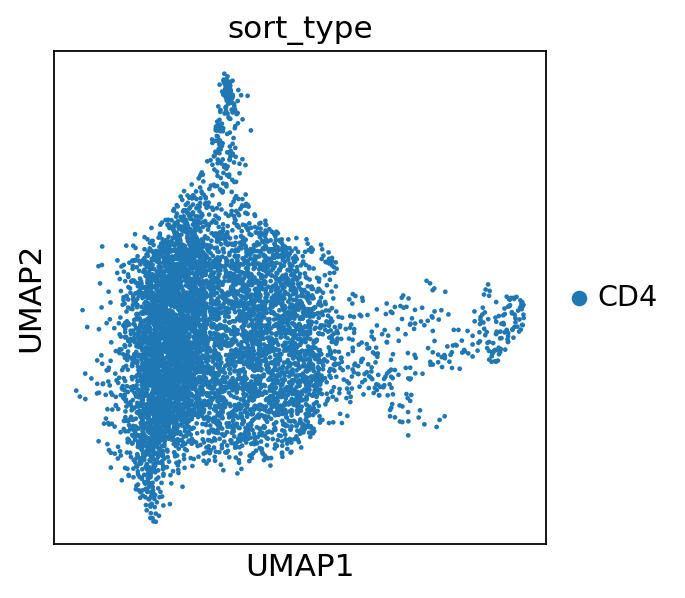

In [139]:
sc.pl.umap(adata_CD4, color=["sort_type", "CD4", "CD8B"], ncols=3)

### How would you sort for CD8?
#### Create an object for CD8 sorted cells and plot it as a UMAP


KeyError: 'Could not find key CD4 in .var_names or .obs.columns.'

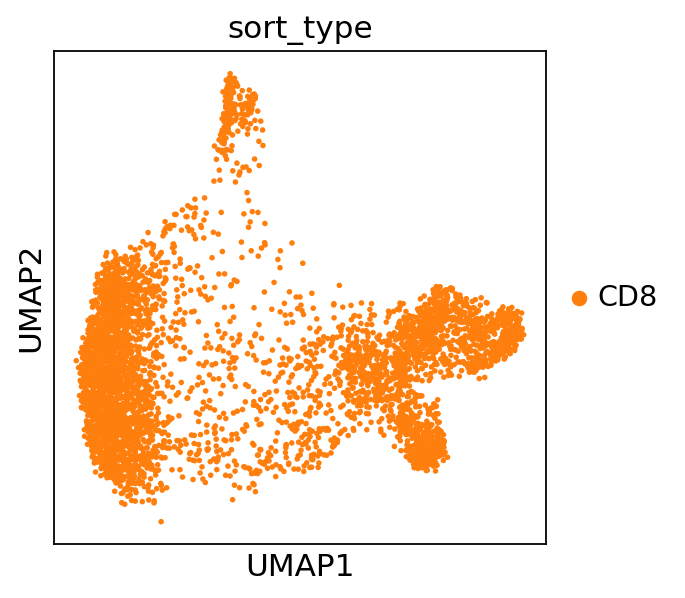

In [140]:
adata_CD8 = adata[adata.obs["sort_type"] == "CD8"]
adata_CD8.obs
sc.pl.umap(adata_CD8, color=["sort_type", "CD4", "CD8B"], ncols=3)

### Repeat for DP sort..

KeyError: 'Could not find key CD4 in .var_names or .obs.columns.'

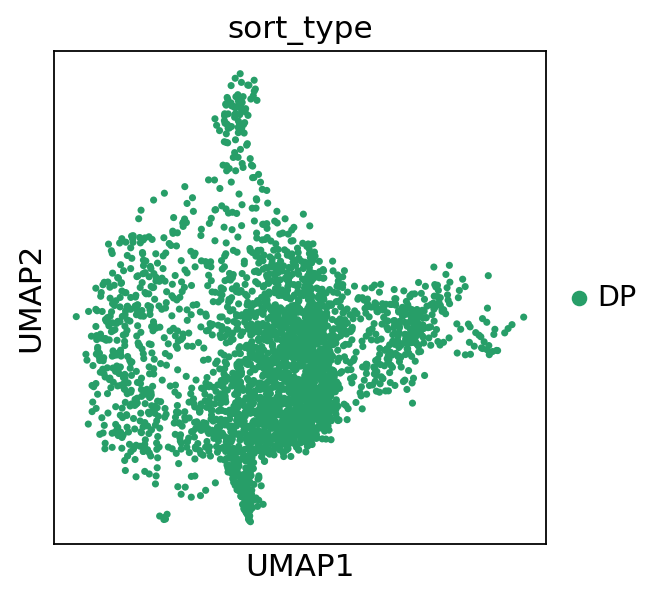

In [141]:
adata_DP = adata[adata.obs["sort_type"] == "DP"]
adata_DP.obs
sc.pl.umap(adata_DP, color=["sort_type", "CD4", "CD8B"], ncols=3)

## expression of CD4 in general isn't great... But most of the DP sorted cells seem to sit closer to the middle where CD4-sorted cells are.

## Another way of plotting...

## How would you visualise different T cell marker genes?

Earlier, we saw genes CD4, CD8B. What are other cell surface markers found on T cells?

Some hints from https://www.nature.com/articles/s41467-019-12464-3

In [142]:
sc.pl.umap(
    adata,
    color=[
        "CD4",
        "CD8B",
        "FOXP3",
        "SELL",
        "CCR7",
        "MKI67",
        "NKG7",
        "GATA3",
        "RORC",
        "CXCR5",
        "CD69",
        "GZMK",
    ],
    ncols=3,
    size=5,
    color_map=tools.cmp(),
)

KeyError: 'Could not find key CD4 in .var_names or .obs.columns.'

<Figure size 1159.2x1280 with 0 Axes>

In [143]:
adata.uns["log1p"]
# {'base': None}

{'base': None}

Let's just save this...

In [144]:
adata.write_h5ad("adata_processed_v2_MS_070823.h5ad", compression="gzip")

# 4. Batch Correction

##### There are a number of methods or algorithms that can combine diverse datasets and remove batch effects. We call that batch correction.

##### Batch balanced k nearest neighbour (BBKNN) is a fairly recent algorithm that is "one to two orders of magnitude faster than existing methods". More info: https://academic.oup.com/bioinformatics/article/36/3/964/5545955

##### BBKNN is batch effect removal tool that can be directly used in the scanpy workflow.
##### It serves as an alternative to scanpy.pp.neighbors(), with both functions creating a neighbour graph for subsequent use in clustering, pseudotime and UMAP visualisation

In [ ]:
## why do we want to batch-correct? Especially in cases where there are "variation" in your dataset such as multiple donors, you will usually see these coming up and influencing your data structure.
cluster_small_multiples(adata, "donor")

## Batch correction with BBKNN

Running BBKNN
https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html

To run BBKNN, we need to start from pre-harmony object so import the file you have previously saved in:

In [145]:
adata = sc.read_h5ad("adata_processed_v2_MS_070823.h5ad")

In [146]:
adata.uns["log1p"]

{}

Note it is empty now - this happens after the save h5ad step! https://github.com/scverse/scanpy/issues/2239

Install `bbknn` if you haven't. Just uncomment the next line and run it.

In [147]:
# !pip install bbknn

#### Apply bbknn to batch correct by sample

In [148]:
sc.external.pp.bbknn(adata, batch_key="sample")

In [149]:
try:
    adata.uns.pop("log1p")
except:
    pass
# if you don't use the saved h5ad, but just continues... output: 'base' : None
# this code chunk will automatically remove the problematic slot if it's there.

### Plotting the neighbourhood graph using bbknn

Note: we skip neighbourhood construction step as bbknn does that already
min_dist : float (default: 0.5).

The effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points. The value should be set relative to the spread value, which determines the scale at which embedded points will be spread out.

The default in the umap-learn package is 0.1. Try inserting different values to find your personal preference in the next few steps through visualisation.

In [150]:
sc.tl.umap(adata, min_dist=0.3)

#### How would you visualise this across the three main T cell types? You can do a loop too

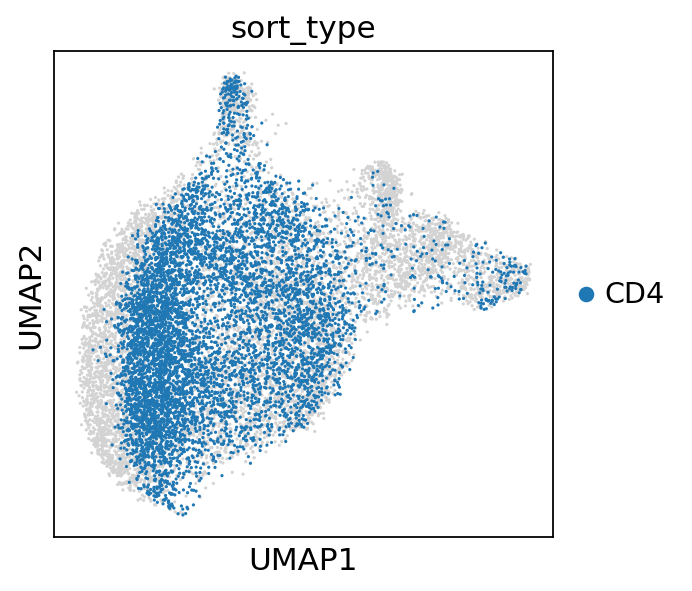

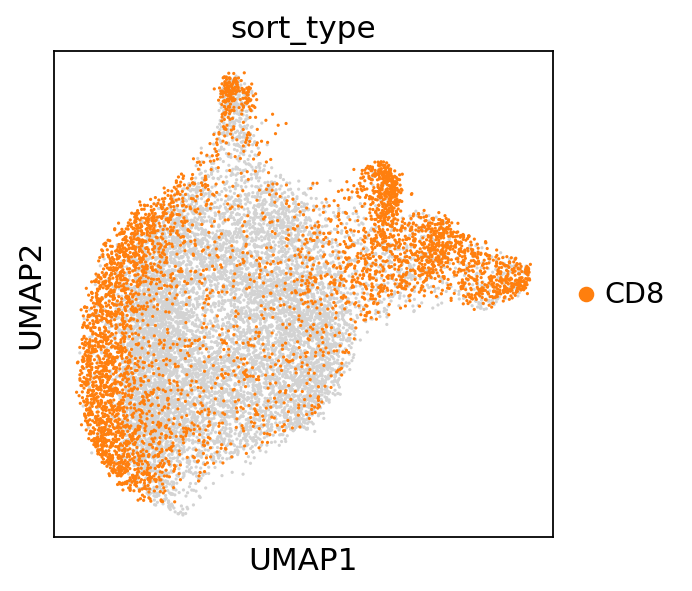

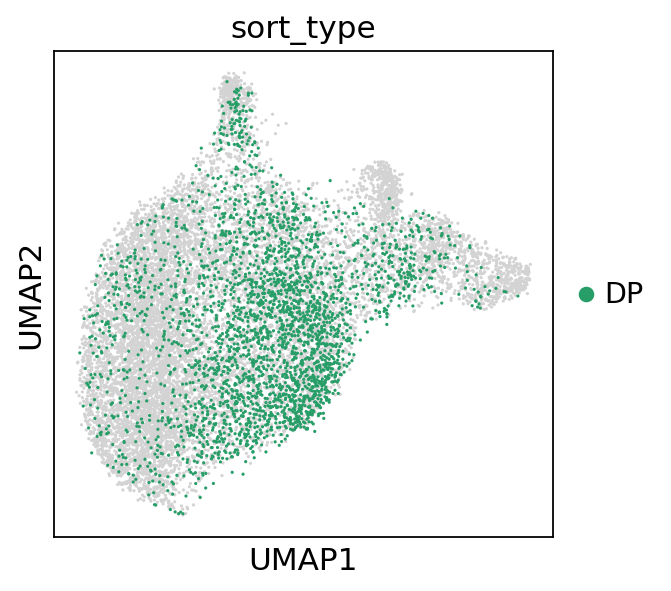

In [151]:
for g in ["CD4", "CD8", "DP"]:
    sc.pl.umap(
        adata,
        color=["sort_type"],
        groups=g,
        na_in_legend=False,
    )

#### How would you visualise by donor? Create a different loop this time and plot the UMAP:

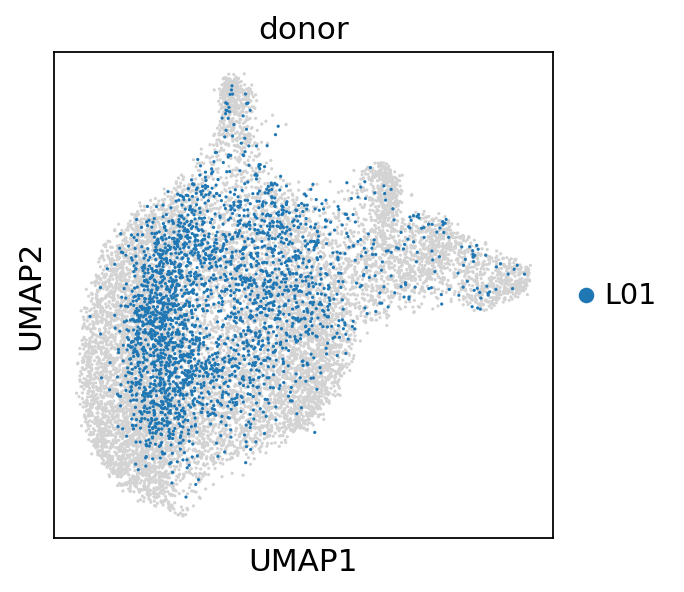

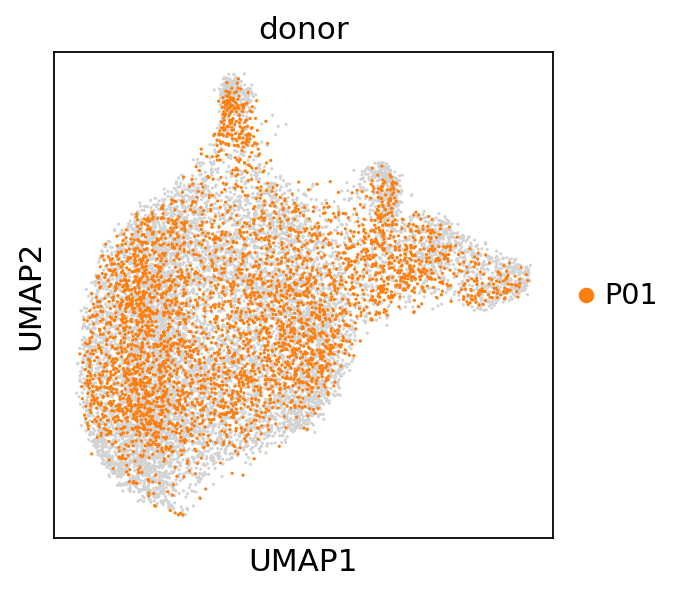

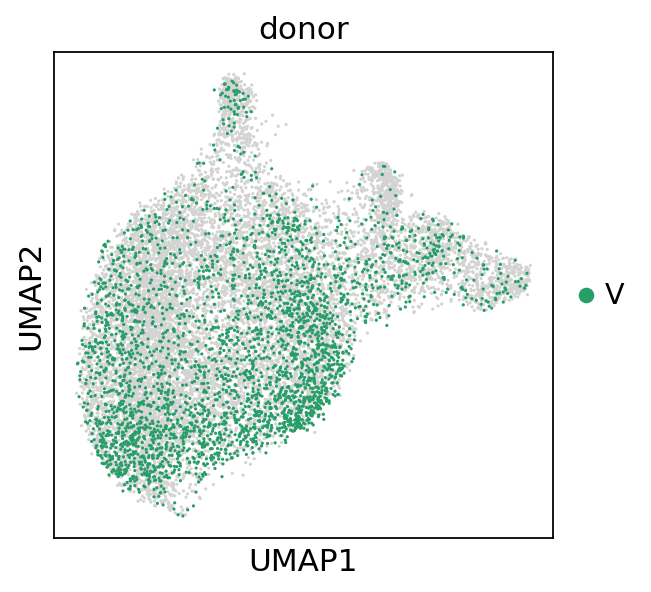

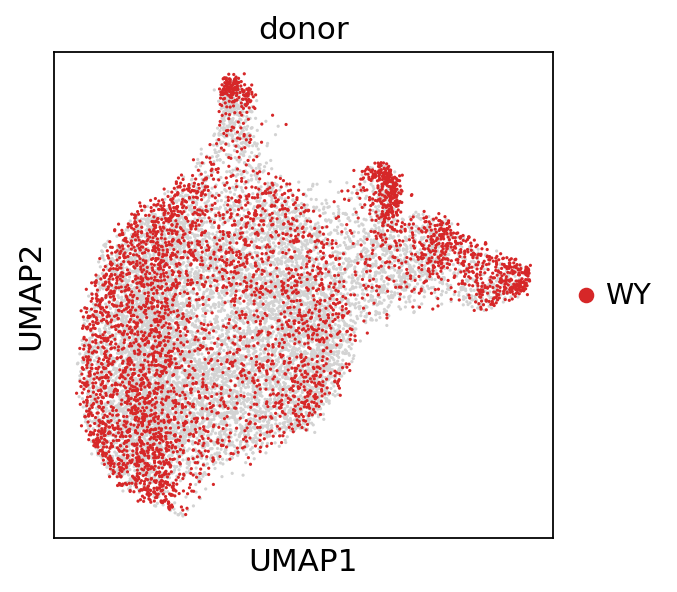

In [152]:
adata.obs["donor"]  # L01, P01, V, WY
# visualise this..
for d in ["L01", "P01", "V", "WY"]:
    sc.pl.umap(
        adata,
        color=["donor"],
        groups=d,
        na_in_legend=False,
    )

### Inspect the changes post-batch correction.

#### Now how do you sort for CD4 T cells? And then display them in UMAPs?

KeyError: 'Could not find key CD4 in .var_names or .obs.columns.'

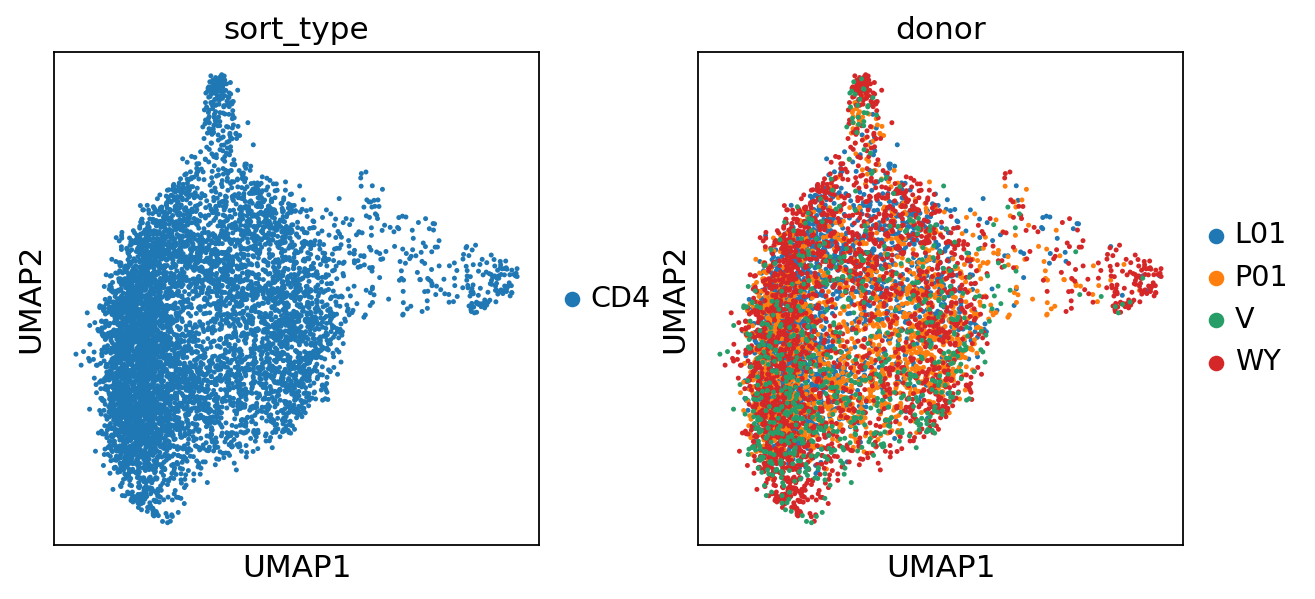

In [153]:
adata_CD4 = adata[adata.obs["sort_type"] == "CD4"]
adata_CD4.obs
sc.pl.umap(adata_CD4, color=["sort_type", "donor", "CD4", "CD8B"], ncols=4, size=20)

### Inspect changes post-batch correction

#### Now how do you sort for CD8 T cells? And then display them in UMAPs?

In [ ]:
adata_CD8 = adata[adata.obs["sort_type"] == "CD8"]
adata_CD8.obs
sc.pl.umap(adata_CD8, color=["sort_type", "donor", "CD4", "CD8B"], ncols=4, size=20)

#### Now how do you sort for DP T cells? And then display them in UMAPs?

In [ ]:
adata_DP = adata[adata.obs["sort_type"] == "DP"]
adata_DP.obs
sc.pl.umap(adata_DP, color=["sort_type", "donor", "CD4", "CD8B"], ncols=4, size=20)

Why is there are there CD4-sorted T cells also found in the CD8 cluster, but with low expression of CD4??

Let's visualise some QC metrics..   Nothing seem too out of the blue.
Maybe downstream, if needed can just recluster and compare. The tail bit of umap seems to be a bit higher in mito content.


In [ ]:
adata.obs
# n_genes_by_counts, total_cpunts, pct_count_mt, filter_rna

sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    ncols=3,
    size=20,
    color_map=tools.cmp(),
)

### How do you visualize the expression of common T cell markers across the entire data set in three columns?

Hint: Using the same markers as we did earlier?

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "CD4",
        "CD8B",
        "FOXP3",
        "SELL",
        "CCR7",
        "MKI67",
        "NKG7",
        "GATA3",
        "RORC",
        "CXCR5",
        "CD69",
        "GZMK",
    ],
    ncols=3,
    size=5,
    color_map=tools.cmp(),
)

### Comments:
These cells are not too different transcriptionally - because they are simply T cells?
Also, umap seems to cluster more based on "activation status" and then "cell lineage"
But we can see that most of the DP cells are located within the middle where the bulk of CD4 cells are.

## Save post-BBKNN

In [155]:
adata.write_h5ad("adata_processed_v2_BBKNN_MS_100823.h5ad", compression="gzip")

In [ ]:
sc.external.pp.bbknn(adata, batch_key="donor")

In [ ]:
sc.tl.umap(adata, min_dist=0.3)

### How do you visualise CD4, CD8 and DP T cells by donor post-BBKNN batch correction?

In [ ]:
for g in ["CD4", "CD8", "DP"]:
    sc.pl.umap(
        adata,
        color=["sort_type"],
        groups=g,
        na_in_legend=False,
    )

### How to visualise individual UMAPS based of each donor type?

In [ ]:
adata.obs["donor"]  # L01, P01, V, WY

for d in ["L01", "P01", "V", "WY"]:
    sc.pl.umap(
        adata,
        color=["donor"],
        groups=d,
        na_in_legend=False,
    )

Not much difference... So just go back to previous

# Read in Data post-BBKNN

In [154]:
adata = sc.read_h5ad("adata_processed_v2_BBKNN_MS_100823.h5ad")
try:
    adata.uns.pop("log1p")
except:
    pass

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'adata_processed_v2_BBKNN_MS_100823.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
sc.tl.umap(adata, min_dist=0.3)

#### Visualise this, you can do it with a loop too:

In [ ]:
for g in ["CD4", "CD8", "DP"]:
    sc.pl.umap(adata, color=["sort_type"], groups=g, size=20)

### How do I view proportion of CD4 expression in CD8+ cells?

Hint: you can use a method of score_genes under scanpy. Then visualise the score by plotting the umap.

In [ ]:
sc.tl.score_genes(adata, gene_list=["CD4", "CD8B", "CD8A"], score_name="CD4.CD8.score")

In [ ]:
sc.pl.umap(adata, color="CD4.CD8.score", size=10)

### Now that we've seen what a batch corrected data is visualised on a UMAP, let's compare it with the UMAP of our adata:
We'll name the previous non-batch corrected data as "preadata"

In [ ]:
preadata = sc.read_h5ad("adata_processed_v2_MS_070823.h5ad")
try:
    preadata.uns.pop("log1p")
except:
    pass

In [ ]:
sc.tl.umap(preadata, min_dist=0.3)

In [ ]:
sc.tl.score_genes(
    preadata, gene_list=["CD4", "CD8B", "CD8A"], score_name="CD4.CD8.score"
)

In [ ]:
sc.pl.umap(preadata, color="CD4.CD8.score", size=10)

 - So can you see the difference in the UMAPs pre- and post-batch correction?

Now, moving back to our batch corrected adata object, let's check the annotations of variables:

In [ ]:
adata.var

Next, let's use an existing CD4/CD8 gene set from Szabo et al. to score the expression of various CD4/CD8 markers on our dataset.

Read in the csv file and label it "szabo"

In [ ]:
szabo = pd.read_csv("geneset/Szabo_T_cell_gene_modules.txt", sep="\t")
szabo

Embed a score to the Szabo's "CD4/CD8" gene list and name the score as "CD4/CD8_geneset"

In [ ]:
sc.tl.score_genes(adata, gene_list=szabo["CD4/CD8"], score_name="CD4/CD8_geneset")

# So if it scores higher = it is more CD4-like...

Plot the usual CD4, CD8 genes together with two other T cell markers: CD44 and CD27 which are involved in acquiring activation, whereas CD27 is high on naive cells and lost upon activation.

In [ ]:
sc.pl.umap(
    adata,
    color=["CD4/CD8_geneset", "sort_type", "CD4", "CD8B", "CD27", "CD44"],
    ncols=3,
    size=5,
)

It's a bit weird but the CD/CD8 marker expression doesn't fully coincide with the CD4/CD8 lineage of sorted identities.

Let's do unsupervised clustering and see if there is any way we can understand CD4 vs CD8 on clusters.

# 5. Redo UMAP

# Try running Leiden unsupervised clustering:

Run leiden clustering with scanpy (BBKNN already has a neighbourhood construction step so can skip this)

In [ ]:
sc.tl.leiden(adata, resolution=2.0)

#### Plot a UMAP and choose a resolution ("size") of 20 clusters:

Reference for what other types of resolution mean:

resolution 1.0 (10 clusters), resolution 1.5 (12 clusters), resolution 1.8 (15 clusters), resolution 2.0 (16 clusters) - but looks heaps better!


In [ ]:
sc.pl.umap(adata, color="leiden", size=20)

In [ ]:
# putting legend on top
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontoutline=2, size=10)

In [ ]:
### just getting how many cells are there per cluster
adata.obs.groupby(["leiden"]).apply(len)

Creating bar plot distribution per cluster

In [ ]:
import matplotlib.pyplot as plt

#  https://pbpython.com/pandas-crosstab.html
# basically, cross-tabbing relates to two columns/ series together...

pd.crosstab(adata.obs["donor"], adata.obs["leiden"])

In [ ]:
########   generating it as frequency...
# axis : t specifies the axis along which the means are computed
# https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean
#   Usually axis=0 is said to be "column-wise" (and axis=1 "row-wise")

pd.crosstab(adata.obs["donor"], adata.obs["leiden"]).apply(
    lambda r: r / r.sum() * 100, axis=1
)

##### Quick jump to see what axis = 0 or 1 works...

```python
data = {"A": [1, 2, 3], "B": [4, 5, 6], "C": [7, 8, 9]}

df = pd.DataFrame(data)

print(df)

column_sums = df.sum(axis=0)
print(column_sums)

row_sums = df.sum(axis=1)
print(row_sums)
```

In [ ]:
#### Creating a stacked bar
pd.crosstab(adata.obs["sort_type"], adata.obs["leiden"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

 - `bbox_to_anchor=(1, 0.5)`: This parameter specifies the position of the legend in relation to the axes. In this case, (1, 0.5) means the legend will be placed at the right side of the plot, and vertically centered (at 50% height of the plot).
 - `loc='center left'`: This parameter determines where the legend should be anchored within the bounding box specified by bbox_to_anchor. In this case, the legend will be positioned along the center-left edge of the bounding box.
 - `frameon=False`: This parameter specifies whether to draw a frame around the legend. By setting it to False, you're indicating that the legend should not have a visible frame.

In [ ]:
### Quickly plot Violin plots for QC...
sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    size=0.1,
    groupby="leiden",
    multi_panel=True,
    rotation=90,
)

# cluster 12 - a lot of mito genes, cluster 15 is basically non-existent!

In [ ]:
## check CD4/CD8 score over cluster.. - higher score = more CD4.. - cluster 2,3,4, 6,7,8, 11,13,14
sc.pl.matrixplot(adata, "CD4/CD8_geneset", groupby="leiden")

This is in line with UMAP structure governed mainly by activation etc... Whereas lineage of CD4/CD8 of sorted identities are not distinct in the UMAP. CD4-like cells tend to sit on the upper half!

In [ ]:
sc.pl.violin(
    adata,
    ["CD4", "CD8A", "CD8B"],
    size=0.1,
    groupby="leiden",
    multi_panel=True,
    rotation=90,
)

# 6. Refining clusters based on marker gene expression
# (Manual way #1)

Using the Leiden clusters, rank the highly expressed genes for each cluster using a dot plot.
Try adding a new key to refine the number of clusters. Label it as "leiden_A"

In [ ]:
sc.tl.leiden(adata, key_added="leiden_A")
sc.pl.umap(
    adata, color=["leiden", "leiden_A"], legend_fontoutline=2, legend_loc="on data"
)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden_A", method="wilcoxon")

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=5, min_logfoldchange=0.5, standard_scale="var", color_map="viridis"
)

Now label each cluster with an annotation based on the most highly expressed genes while genes that are housekeeping or non-specific can be assigned to "Ambiguous" if they are not genes of interest.
Also consider the fraction of cells and their mean gene expression in tandem

You can also look at the genes in a tabular format for easier viewing. Still, use it in tandem with the dotplot above.

In [ ]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

#### Now name the clusters based on the listed genes together with references to literature.

Notice that most of the clusters have lots of non-specific annd/or housekeeping genes that makes it hard to name the clusters.

So you can also just manually inspect and plot a few genes using a cell marker dictionary that we will then used to label the above clusters.

**I am leaving the next few lines of code partlially blank so that you can decide what kind genes to plot and how to annotate your celltypes. If you just run as it, you will encounter errors.**

In [ ]:
cellmarker_dict = {
    "T cell": ["CD3D", "TRAC"],
    "NK": ["NCAM1", "NCR1"],
    "CD4 vs CD8": ["CD4", "CD8B"],
    "Memory": ["SELL", "CCR7", "CD44"],
    "Th1": [],
    "Cytokines": [],
    "Chemokines": [],
    "Exhausted": [],
    "Other": [],
}

In [ ]:
sc.pl.dotplot(
    adata, cellmarker_dict, groupby="leiden_A", standard_scale="var", color_map="Blues"
)

### To map the identified clusters to a cell type annotation label

In [ ]:
celltypesannot = {
    "0": "",
    "1": "",
    "2": "",
    "3": "",
    "4": "",
    "5": "",
    "6": "",
    "7": "",
    "8": "",
    "9": "",
}
# add a new '.obs'column called 'cell type' by mapping clusters to annotation using pandas 'map'function
adata.obs["cell type"] = adata.obs["leiden_A"].map(celltypesannot).astype("category")

In [ ]:
sc.pl.umap(
    adata,
    color="cell type",
    legend_loc="on data",
    frameon=False,
    legend_fontsize=7,
    legend_fontoutline=2,
)

In [ ]:
adata2 = adata[
    adata.obs["cell type"].isin(
        [
            "",
            "",
            "",
        ]
    )
].copy()
sc.pl.umap(adata2, color="cell type")

In [ ]:
adata2.write("celltypes_annot_01.h5ad")

In [ ]:
adata2 = sc.read_h5ad("celltypes_annot_01.h5ad")  # run this if reimporting
adata2

So the above steps would be how you run a manual annotation and you can refine the clusters further using your newly labeled object "adata2"

# 7. Other ways of refining cluster annotations:

## Alternative method of cluster annotations: Automated Celltypist annotation

### First, write out the raw data for input for celltypist

In [ ]:
adata.raw.to_adata().write_h5ad(
    "adata_processed_v2_BBKNN_MS_raw-for_celltypist_300823.h5ad", compression="gzip"
)

#### Quick note... Kelvin also did a comparison on the pre-batch-correction data, but since we are happy with batch correction.. just continue on.

### Make a directory for the output after running celltypist on our data

In [ ]:
!mkdir celltypist_bbknn

#### Run celltypist on our processed-BBKNN-batch corrected data and allow it to predict labels on each single cell with all the specifications needed.

#### The labels will be given a variable name of "majority_voting"

In [ ]:
!celltypist --indata adata_processed_v2_BBKNN_MS_raw-for_celltypist_300823.h5ad --model Immune_All_Low.pkl --outdir celltypist_bbknn --majority-voting

#### Import and label the object for predicted_labels.csv as "celltypistdf1" and set an index_col=0.

index_col: This is to allow you to set which columns to be used as the index of the dataframe. The default value is None, and pandas will add a new column start from 0 to specify the index column. It can be set as a column name or column index, which will be used as the index column.

#### Then run the new object

majority_voting: predicted labels after majority voting in local subclusters

In [ ]:
celltypistdf1 = pd.read_csv("celltypist_bbknn/predicted_labels.csv", index_col=0)
celltypistdf1

#### Check the columns of adata:

In [ ]:
adata.obs

#### Include the majority_voting data from celltypistdf1 in the adata - Label it as "celltypist_majority_voting"

In [ ]:
adata.obs["celltypist_majority_voting"] = pd.Series(celltypistdf1["majority_voting"])
adata.obs.info()

#### Check the columns that you've added the new column in correctly:

In [ ]:
adata.obs

#### Data can also be imported this way without "pd.Series" at the start - not sure what difference is!:

adata.obs["celltypist_majority_voting"] = celltypistdf1["majority_voting"]

#### Visualise the data via umap

##### Hint: color it by your new celltypist labels

In [ ]:
sc.pl.umap(adata, color=["celltypist_majority_voting"], size=20)

### Plot distribution by sorting by cell type

In [ ]:
pd.crosstab(adata.obs["sort_type"], adata.obs["celltypist_majority_voting"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

### Plot a crosstab chart by sorting into CD4, CD8 and DP using the package matplotlib.pyplot:

In [ ]:
import matplotlib.pyplot as plt

pd.crosstab(
    adata.obs["celltypist_majority_voting"],
    adata.obs["sort_type"],
).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

### Plot a UMAP and colour it by leiden and place the legend 'on data'

In [ ]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontoutline=2, size=10)

In [ ]:
pd.crosstab(adata.obs["leiden"], adata.obs["celltypist_majority_voting"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

At the end of all these, a theme has emerged:
CD4 sorted cells are mostly "naive"-like
CD8 sorted cells are mostly "cytotoxic"
DP are more related to CD4s, but have some differentianted Th cells

#### But if this is the case, none of the current annotation will have DP cells as a whole - the question is are DP cells more related to CD4/CD8 cells. So... we will group all DP cells and annotate them as DP cells without further clustering etc.

#### So next, create a new column in adata called  "celltypist_annotation":

In [ ]:
adata.obs["celltypist_annotation"] = adata.obs["celltypist_majority_voting"]
adata.obs.info()

In [ ]:
# convert from category to object so I can play around...
adata.obs["celltypist_annotation"] = adata.obs["celltypist_annotation"].astype("object")
adata.obs.info()

In [ ]:
### This function works only on object but NOT category!
for i in adata.obs.index:
    if adata.obs.at[i, "sort_type"] == "DP":
        adata.obs.at[i, "celltypist_annotation"] = "DP"
adata.obs.info()

In [ ]:
adata.obs

### Plot a umap and color it by the celltypist annotations.

In [ ]:
sc.pl.umap(adata, color=["celltypist_annotation"], size=20, ncols=2)

## Stop here.... and save and do marker genes etc....

In [ ]:
adata.write_h5ad(
    "adata_processed_v2_BBKNN_celltypist_MS_300823.h5ad", compression="gzip"
)

In [ ]:
adata = sc.read_h5ad("adata_processed_v2_BBKNN_celltypist_MS_300823.h5ad")
#### NOTE: This step is only necessary if you are running from any of the SAVED H5ad object, because adata.uns['log1p'] is an empty dictionary! So will trigger error when running any DGEA..
# pop is used to remove and return an element from a collection (if assigned to something), here it is to simply remove log1p
try:
    adata.uns.pop("log1p")
except:
    pass
adata

## Finding Marker Genes Manually

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

Plot the above out:

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)  # sharey means each panel

Plot it out as dotplot:

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=5, standard_scale="var", color_map="viridis", min_logfoldchange=1
)

Let's try to plot my marker genes of "CD4", "CD8B", "FOXP3", "CTLA4", "SELL", "CCR7", "MKI67", "NKG7", "GATA3", "RORC", "CXCR5", "CD69", "GZMK", "BCL6", "TRAV1-2" - label this set of genes as "my_genes", and plot it as a dotplot

In [ ]:
my_genes = [
    "CD4",
    "CD8B",
    "FOXP3",
    "CTLA4",
    "SELL",
    "CCR7",
    "MKI67",
    "NKG7",
    "GATA3",
    "RORC",
    "CXCR5",
    "CD69",
    "GZMK",
    "BCL6",
    "TRAV1-2",
]
sc.pl.dotplot(adata, var_names=my_genes, groupby="leiden", color_map="viridis")

Plot Violin plots for QC using the stacked_violin function:

In [ ]:
sc.pl.stacked_violin(
    adata,
    my_genes,
    groupby="leiden",
    row_palette="viridis",
    colorbar_title="median expression",
)

Plot a stacked_violin chart again but groupby as 'celltypist_annotation'

In [ ]:
sc.pl.stacked_violin(
    adata,
    my_genes,
    groupby="celltypist_annotation",
    row_palette="viridis",
    colorbar_title="median expression",
)

Show the top 10 ranked genes for each cluster as a dataframe using the `rank_genes_groups` function

In [ ]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

Plot the umap and color by 'leiden' and set a size of 20:

In [ ]:
sc.pl.umap(adata, color="leiden", size=20)

Redo the above steps with celltypist_annotation:

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="celltypist_annotation", method="wilcoxon")

Plot it out as dotplot with rank_genes_groups

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=10, standard_scale="var", color_map="viridis", min_logfoldchange=1
)

Plot violin plots for QC with 'my_genes':

In [ ]:
my_genes = [
    "CD4",
    "CD8B",
    "FOXP3",
    "IL2RA",
    "CTLA4",
    "GZMK",
    "NKG7",
    "CCL5",
    "SELL",
    "CCR7",
    "CD44",
    "CD27",
    "TRAV1-2",
    "KLRG1",
    "CX3CR1",
    "CD69",
    "ITGA1",
    "CXCR6",
]
sc.pl.stacked_violin(
    adata,
    my_genes,
    groupby="celltypist_annotation",
    row_palette="viridis",
    colorbar_title="median expression",
)


Plot umap with clusters coloured by celltypist_annotation

In [ ]:
sc.pl.umap(adata, color="celltypist_annotation", size=10)

Show the top 10 ranked genes for each cluster as a dataframe using 'rank_genes_groups'

In [ ]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)

Do you want to try and give each cluster your own annotation and see if it agrees with the celltypist ones?

This marks the end of the tutorial. Good job!